<a href="https://colab.research.google.com/github/serafinnavarro/passenger_satisfaction/blob/main/analisis_predictivo_satisfaccion_pasajeros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

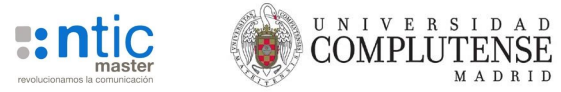

<font size=7, color='orange'>**‘Análisis predictivo de la satisfacción de pasajeros en una aerolínea’**

**Serafín Navarro César. Marzo - 2023**

Este trabajo tiene como objetivo la clasificación de la satisfacción del pasajero de una aerolínea a través de unas variables de entrada definidas. Hay dos áreas principales de estudio: la identificación de los factores más importantes y el análisis de un modelo efectivo para la predicción de la variable objetivo. 

Para el primer punto se ha hecho un análisis descriptivo de los datos y un preprocesamiento a través de la depuración de los datos y transformación y selección de variables. Con la eliminación de la mitad de las variables y a través de un modelo de regresión logística, se ha llegado a la conclusión que los niveles superiores de categorías como el embarque online o servicio de Wi-Fi tiene influencia positiva en la variable objetivo, también un viajero por motivos de negocios y fidelizado.

A continuación, se ha procedido modelos que aumenten la precisión y bondad de ajuste al modelo anterior. Modelos de redes y XGBoost se posicionan como los más prometedores. También se ha realizado un proceso de AutoML comparando más de 3000 modelos diferentes y se ha buscado los hiperparámetros del modelo XGBoost. Comparando el modelo óptimo de AutoML y el tuneado de XGBoost, se ha elegido finalmente el segundo obteniendo una exactitud del 95% (97% de especificidad y 92% de sensibilidad). 

Por último, se interpretan los resultados de este modelo a través de los SHAP values siendo las variables binarias (tipo de viaje y pasajero respecto a su fidelización) las más importantes en la predicción de la satisfacción de un pasajero.




# Librerías

In [1]:
#Instalación de paquetes

#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install scipy
#!pip install sklearn
#!pip install patsy
#!pip install warnings
#!pip install re 
#!pip install tensorflow
#!pip install hyperopt
#!pip install tpot
#!pip install plotly.io
#!pip install xgboost
#!pip install shap

In [2]:
# Librerías Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Librerías Jupyter Notebook
#import plotly.io as pio
#pio.renderers.keys()
#pio.renderers.default = 'notebook'

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option("display.max_columns", None)
sns.set_style('darkgrid')
import scipy.stats as stats
import patsy
import warnings
warnings.filterwarnings("ignore")
import re
#import shap

In [72]:
"""Funciones de sklearn y otros"""
#Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

#Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

#Algorithms
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import logit 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb

#Model Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold

#Model goodness
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Model tunning
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
#from tpot import TPOTClassifier

In [7]:
"""Redes"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# Funciones del usuario

In [8]:
#Fijamos la semilla para todo el notebook
seed = 123

In [9]:
## Función para categorizar las variables con 10 o menos valores únicos
def categorizar(data):
    for col in data.columns:
        if data.nunique()[col] < 11:
            data[col] = data[col].astype('category')
    return data

## Función para cambiar una cadena de simbolos por "_" al nombre de variable
def renombrar(data, simb):

  for col in data.columns:
      if col.endswith("0"):
        col2 = ''.join((col,'_'))
      else:
        col2 = col
      col3 = re.sub(simb, "_", col2)
      data.rename(columns={col : col3},
                       inplace = True)
  return data

## Función para eliminar columnas
def eliminar_columnas(data, col = []):
    data = data.drop(col, axis=1)
    return data

## Función general para graficar las columnas que se deseen
def biplot(data, cols = [], obj = None):
    if cols == []:
        cols = data.columns
    for col in cols:
        if data[col].dtype.name != 'category':
            print('Variable continua : '+col)
            plt.figure(figsize=(10,3))
            plt.subplot(1,2,1)
            sns.histplot(data=data, x=col, hue=obj, bins=20)
            plt.subplot(1,2,2)
            sns.boxplot(data=data, x=col, hue=obj)
            plt.show()
        else:
            print('Variable categórica : '+col)
            sns.countplot(data=data, x=col, hue=obj)
            plt.show()
    

In [10]:
## Función manual de winsor con clip+quantile 
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))

## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):
    print(col.name)
    # Condición de asimetría y aplicación de criterio 1 según el caso
    if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
    else:
        criterio1 = abs((col-col.median())/col.mad())>8

    # Calcular primer cuartil     
    q1 = col.quantile(0.25)  
    # Calcular tercer cuartil  
    q3 = col.quantile(0.75)
    # Calculo de IQR
    IQR=q3-q1
    # Calcular criterio 2 (general para cualquier asimetría)
    criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
    lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
    upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
    # Salida según el tipo deseado
    if clas == 'check':
        return(lower*100,upper*100,(lower+upper)*100)
    elif clas == 'winsor':
        return(winsorize_with_pandas(col,(lower,upper)))
    elif clas == 'miss':
        print('\n MissingAntes: ' + str(col.isna().sum()))
        col.loc[criterio1&criterio2] = np.nan
        print('MissingDespues: ' + str(col.isna().sum()) +'\n')
        return(col)

In [11]:
def imputar_NA(data, cols, imputer):
    #Rellena los NAs a través de los vecinos 'cols'
    #Nos servirá para todas las variables que estén tengan NAs
    X = data[cols]
    X_imputed = imputer.fit_transform(X)
    data2 = data.copy()
    data2[cols] = X_imputed
    for col in cols:
        if data[col].dtype.name != 'category':
            print('Variable continua : '+col)
            plt.figure(figsize=(10,3))
            plt.subplot(1,2,1)
            sns.histplot(data=data, x=col, bins=20)
            print('Variable continua escalada : '+col)
            plt.subplot(1,2,2)
            sns.histplot(data=data2, x=col, bins=20)
            plt.show()
        else:
            print('Variable categórica : '+col)
            plt.figure(figsize=(10,3))
            plt.subplot(1,2,1)
            sns.countplot(data=data, x=col)
            plt.subplot(1,2,2)
            print('Variable categórica escalada: '+col)
            sns.countplot(data=data2, x=col)
            plt.show()
    return data2

# Función para calcular VCramer 
def cramers_v(var1, varObj):
    if not var1.dtypes.name == 'category':
        var1 = pd.cut(var1, bins = 5)
    if not varObj.dtypes.name == 'category': 
        varObj = pd.cut(varObj, bins = 5)        
    data = pd.crosstab(var1, varObj).values
    vCramer = stats.contingency.association(data, method = 'cramer')
    return vCramer

In [12]:
#Función que escala variables numéricas
def escalar(ft, col, scaler=StandardScaler()):
    scaled = scaler.fit_transform(ft[col])
    return scaled

## Función mejor tranformación
# Busca la transformación de variables input de intervalo que maximiza  
# la VCramer o la correlación tipo Pearson con la objetivo
#Repositorio Guillermo Villarino "Nuestras funciones"
def mejorTransf (ft, col, target, name=False, tipo = 'cramer', graf=False):

    # Escalado de datos (evitar fallos de tamaño de float64
    #al hacer exp de número grande)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(ft[[col]])
    vv = []
    for i in scaled:
        vv.append(float(i))
    vv = pd.Series(vv, name=col)
    # Traslación a valores positivos de la variable
    #(sino fallaría log y las raíces)
    vv = vv + abs(min(vv))+0.0001

    # Definimos y calculamos las transformaciones típicas  
    transf = pd.DataFrame({vv.name + '_ident': vv,
                           vv.name + '_log': np.log(vv), 
                           vv.name + '_exp': np.exp(vv), 
                           vv.name + '_sqrt': np.sqrt(vv), 
                           vv.name + '_sqr': np.square(vv),
                           vv.name + '_cuarta': vv**4, 
                           vv.name + '_raiz4': vv**(1/4)})

    # Distinguimos caso cramer o caso correlación
    if tipo == 'cramer':
      # Aplicar la función cramers_v a cada transformación frente a la respuesta
        tablaCramer = pd.DataFrame(transf.apply(lambda x: cramers_v(x, target)), 
                                   columns=['VCramer'])

      # Si queremos gráfico, muestra comparativa entre las posibilidades
    if graf: px.bar(tablaCramer,
                    x=tablaCramer.VCramer,
                    title='Relaciones frente a ' + target.name)\
                    .update_yaxes(categoryorder="total ascending").show()
      # Identificar mejor transformación
    best = tablaCramer.query('VCramer == VCramer.max()').index
    ser = transf[best[0]].squeeze()

    if tipo == 'cor':
        
      # Aplicar coeficiente correlación a cada transformación frente la respuesta
        tablaCorr = pd.DataFrame(
            transf.apply(lambda x: np.corrcoef(x,target)[0,1]),
                                columns=['Corr'])
      # Si queremos gráfico, muestra comparativa entre las posibilidades
        if graf : px.bar(tablaCorr,
                         x=tablaCorr.Corr,
                         title='Relaciones frente a ' + target.name).\
                         update_yaxes(categoryorder="total ascending").show()
      # identificar mejor transformación
        best = tablaCorr.query('Corr.abs() == Corr.abs().max()').index
        ser = transf[best[0]].squeeze()

    # Aquí distingue si se devuelve la variable transformada
    #o solamente el nombre de la transformación
    if name:
        return(ser.name)
    else:
        return(ser)


In [13]:
# Función para generar la fórmula
def ols_formula(df, dependent_var, *excluded_cols):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    for col in excluded_cols:
        df_columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [14]:
#Función para comparación por validación cruzada
def cross_val_model(X, y, name, data, repeated=False,  
                      model=LogisticRegression(random_state=seed), 
                    graph = True,
                      seed=seed):
    if repeated == True:
      cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
    else:
      cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    # Obtenemos los resultados de R2 para cada partición tr-tst
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    for score in scores:
      data.loc[len(data)] = [name, score]
    # Sesgo y varianza
    #print("Media scoring "+str(np.mean(scores)))
    #print("Desviación típica "+str(np.std(scores)))
    if graph == True:
      plt.figure(figsize=(8,8))
      sns.boxplot(
              x=data.columns[0],
              y=data.columns[1],
              data=data, 
              palette='viridis')
      plt.show()
    return data

In [15]:
# feature selection
def select_features(X_tr, y_tr, X_tst):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_tr, y_tr)
    X_tr_fs = fs.transform(X_tr)
    X_tst_fs = fs.transform(X_tst)
    return X_tr_fs, X_tst_fs, fs

# Tabla de contenidos

* [<font size=4>1. Definición del problema y objetivos</font>](#1)


* [<font size=4>2. Obtención y análisis del dataset</font>](#2)
    * [2.1 Origen del dataset y descripción de las variables](#2.1)
    * [2.2 Análisis descriptivo de los datos y definición de las variables](#2.2)
    * [2.3 Solución manual del problema](#2.3)


* [<font size=4>3. Preparación de los datos</font>](#3)
    * [3.1 Depuración de datos](#3.1)
    * [3.2 Transformación de variables](#3.2)
    * [3.3 Selección de variables](#3.3)
    * [3.4 Análisis de los factores](#3.4)
    
    
* [<font size=4>4. Modelos</font>](#4)
    * [4.1 Redes neuronales](#4.1)
    * [4.2 Random Forest, Gradient Boosting, Gaussian NB y SVM](#4.2)
    * [4.3 XGBoost](#4.3)
    * [4.4 Tree-based Pipeline Optimization Tool (TPOT)](#4.4)
    * [4.5 Selección de modelos más óptimos](#4.5)
    
    
* [<font size=4>5. Ajuste de modelos</font>](#5)
    * [5.1 Hyperopt](#5.1)
    * [5.2 Elección del modelo ganador](#5.2)
    * [5.3 Discusión de los resultados](#5.3)


* [<font size=4>6. Informe final de conclusiones</font>](#6)


# 1. Definición del problema y objetivos<a id="1"></a>

Este trabajo se va a dividir en dos objetivos claros:
1.	Determinar y cuantificar los factores que afectan en la satisfacción de los clientes.
2.	Analizar y definir un método para predecir la satisfacción de los pasajeros de una manera periódica para monitorizar este indicador.

Para la consecución de estos objetivos se van a repasar los distintos algoritmos/métodos de clasificación binaria supervisada, estableciendo la variable objetivo o respuesta la satisfacción. Estos métodos deberán ser comparados por su capacidad predictiva (sesgo y varianza), gasto computacional e interpretación de los resultados. Por la estructura de la variable respuesta, la métrica a evaluar será la exactitud. Desde el punto de vista de negocio interesa un modelo que es más flexible a fallos en la predicción de verdaderos pasajeros satisfechos y tiene que ser más robusto en la detección de pasajeros que se han mostrado neutrales o insatisfechos. (Habrá que minimizar el error Tipo I).


# 2. Obtención y análisis del dataset<a id="2"></a>

## 2.1 Origen del dataset y descripción de las variables<a id="2.1"></a>

El conjunto de los datos que se ha tomado de un repositorio de Kaggle. (Klein, 2020) de una encuesta a los pasajeros de una aerolínea estadounidense el que se muestran los diferentes factores que afectan a la satisfacción de los pasajeros. La toma original está separada en dos archivos, train y test. Para este trabajo se han fusionado ambos archivos en un solo. En la siguiente table se encuentra una descripción de las variables:

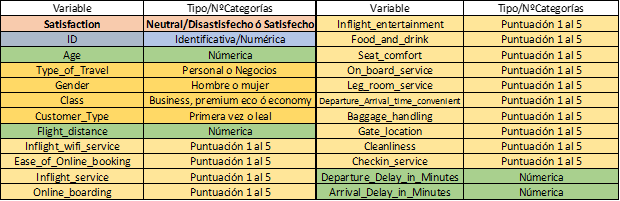

-	Variable objetivo e identificativa (2): Satisfacción e id del pasajero
-	Variables numéricas (4): Variables numéricas con más de 10 valores distintos.
-	Variables categóricas (18): Variables que acogen menos de 10 categorías o niveles diferentes que son numéricas o tipo cadena. En amarillo más claro se destacan las variables categóricas asociadas al valor de la puntuación de la encuesta (denominadas sat_cols).


In [16]:
url2 = 'https://raw.githubusercontent.com/serafinnavarro\
/passenger_satisfaction/main/passenger_satisfaction.csv'
    
df = pd.read_csv(url2)

In [17]:
df.tail(5)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
129875,103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
129876,103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0,0.0,satisfied
129877,103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
129878,103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied
129879,103903,62567,Male,Loyal Customer,27,Business travel,Business,1723,1,3,3,3,1,1,1,1,1,1,4,4,3,1,0,0.0,neutral or dissatisfied


In [18]:
df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [19]:
df = eliminar_columnas(df, ['Unnamed: 0'])

In [20]:
df.shape

(129880, 24)

In [21]:
df.isna().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [22]:
df.duplicated().sum()

0

## 2.2 Análisis descriptivo de los datos y definición de las variables <a id="2.2"></a>

In [23]:
df = categorizar(df)
df = renombrar(df, "\s|-|/")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   id                                 129880 non-null  int64   
 1   Gender                             129880 non-null  category
 2   Customer_Type                      129880 non-null  category
 3   Age                                129880 non-null  int64   
 4   Type_of_Travel                     129880 non-null  category
 5   Class                              129880 non-null  category
 6   Flight_Distance                    129880 non-null  int64   
 7   Inflight_wifi_service              129880 non-null  category
 8   Departure_Arrival_time_convenient  129880 non-null  category
 9   Ease_of_Online_booking             129880 non-null  category
 10  Gate_location                      129880 non-null  category
 11  Food_and_drink            

In [25]:
df.describe()

,id,Age,Flight_Distance,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,64940.500000,39.427957,1190.316392,14.713713,15.091129
std,37493.270818,15.119360,997.452477,38.071126,38.465650
min,1.000000,7.000000,31.000000,0.000000,0.000000
25%,32470.750000,27.000000,414.000000,0.000000,0.000000
50%,64940.500000,40.000000,844.000000,0.000000,0.000000
75%,97410.250000,51.000000,1744.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,1592.000000,1584.000000


In [26]:
df.describe(exclude=np.number)

,Gender,Customer_Type,Type_of_Travel,Class,Inflight_wifi_service,Departure_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,satisfaction
count,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880
unique,2,2,2,3,6,6,6,6,6,6,6,6,6,6,5,6,6,6,2
top,Female,Loyal Customer,Business travel,Business,2,4,3,3,4,4,4,4,4,4,4,4,4,4,neutral or dissatisfied
freq,65899,106100,89693,62160,32320,31880,30393,35717,30563,38468,39756,36791,38703,35886,46761,36333,47323,33969,73452


In [27]:
features = eliminar_columnas(df, ['id', 'satisfaction'])
target = df.satisfaction
id_ = df['id']

In [28]:
bin_cols = ['Gender', 'Customer_Type', 'Type_of_Travel', 'Class']

sat_cols = ['Inflight_wifi_service', 'Departure_Arrival_time_convenient',
        'Ease_of_Online_booking','Gate_location', 'Food_and_drink', 
        'Online_boarding', 'Seat_comfort','Inflight_entertainment', 
        'On_board_service', 'Leg_room_service','Baggage_handling', 
        'Checkin_service', 'Inflight_service', 'Cleanliness']

num_cols = ['Age', 'Flight_Distance',
            'Departure_Delay_in_Minutes',
            'Arrival_Delay_in_Minutes']

cat_cols = bin_cols + sat_cols

Una vez definidas las variables se han analizado gráficamente éstas a través de histogramas y diagrama de cajas y bigotes en el caso de las variables numéricas y diagrama de barras para las categóricas.

Variable respuesta


Variable continua : id


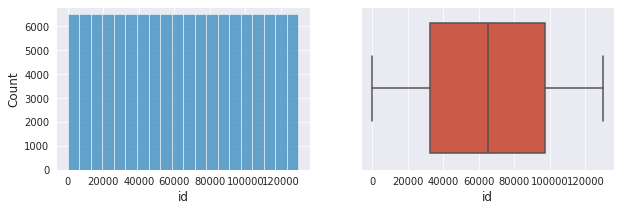

Variable categórica : satisfaction


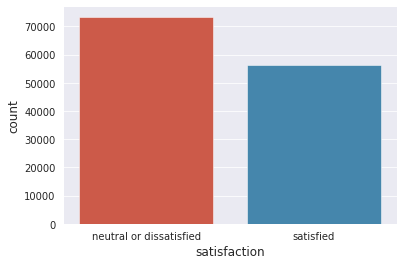

In [29]:
biplot(eliminar_columnas(df, features.columns))

Variables inputs

Variable categórica : Gender


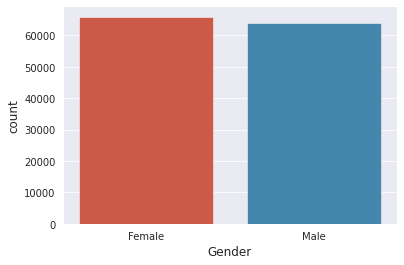

Variable categórica : Customer_Type


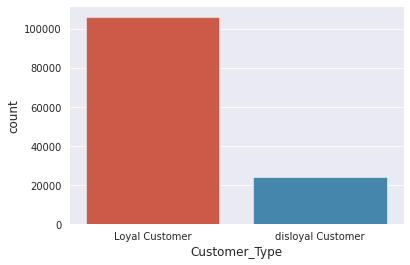

Variable continua : Age


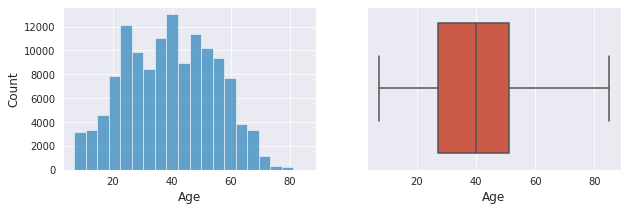

Variable categórica : Type_of_Travel


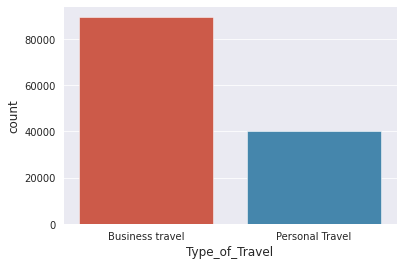

Variable categórica : Class


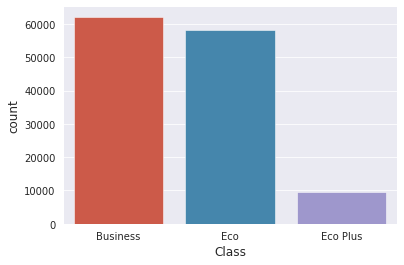

Variable continua : Flight_Distance


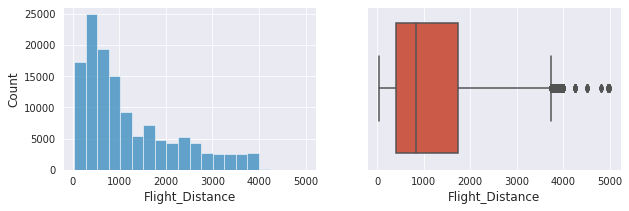

Variable categórica : Inflight_wifi_service


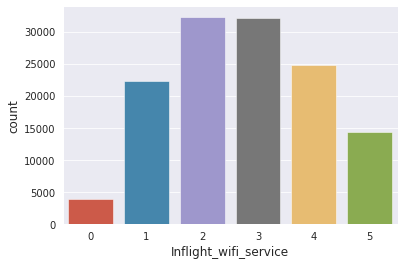

Variable categórica : Departure_Arrival_time_convenient


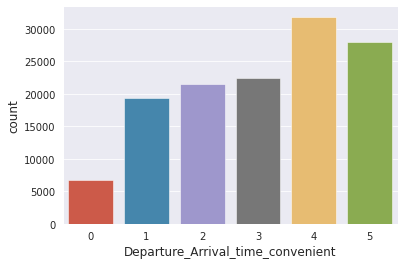

Variable categórica : Ease_of_Online_booking


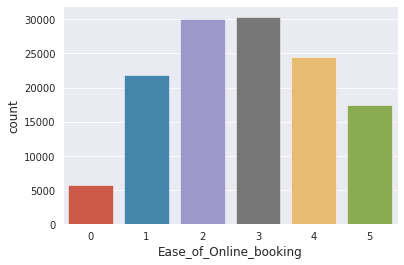

Variable categórica : Gate_location


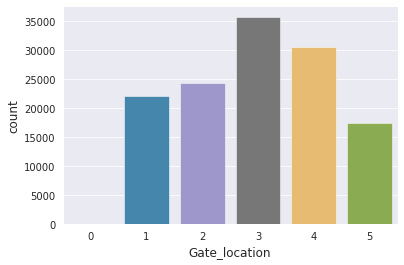

Variable categórica : Food_and_drink


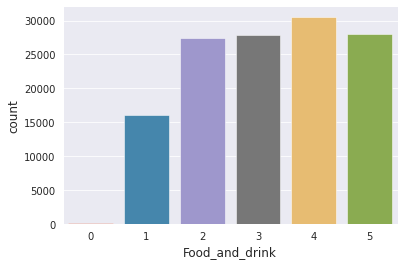

Variable categórica : Online_boarding


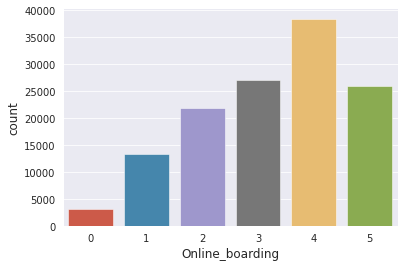

Variable categórica : Seat_comfort


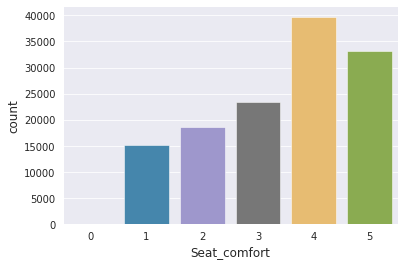

Variable categórica : Inflight_entertainment


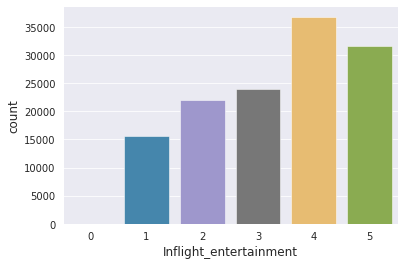

Variable categórica : On_board_service


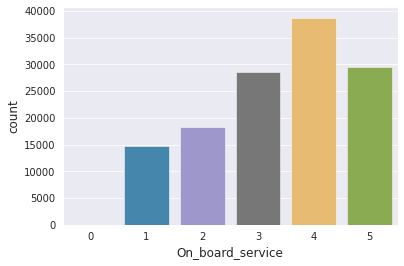

Variable categórica : Leg_room_service


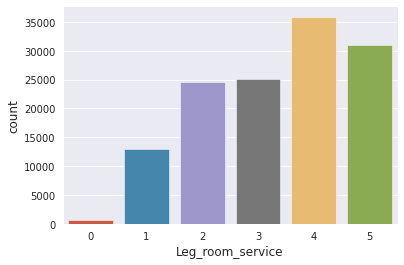

Variable categórica : Baggage_handling


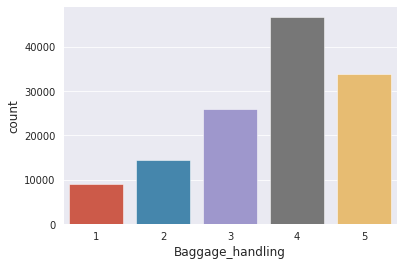

Variable categórica : Checkin_service


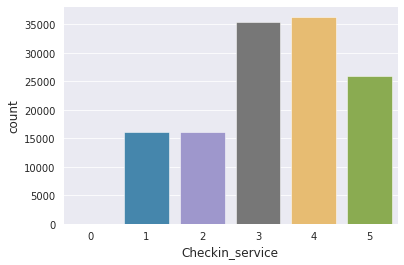

Variable categórica : Inflight_service


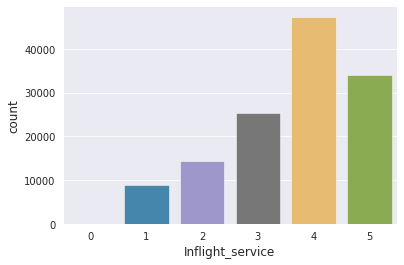

Variable categórica : Cleanliness


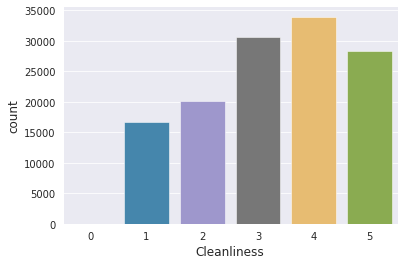

Variable continua : Departure_Delay_in_Minutes


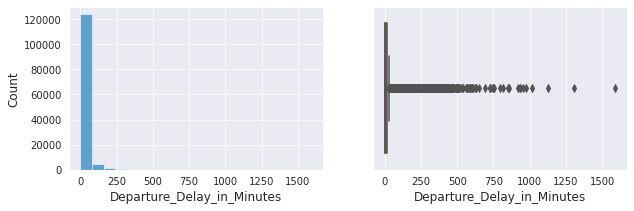

Variable continua : Arrival_Delay_in_Minutes


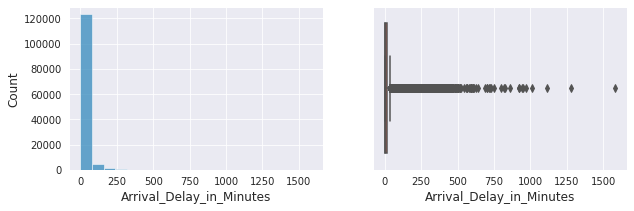

In [ ]:
biplot(features)

Relaciones entre variables

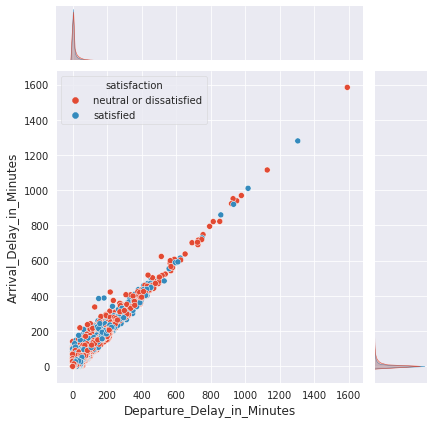

In [ ]:
sns.jointplot(data=df, 
              x='Departure_Delay_in_Minutes', 
              y='Arrival_Delay_in_Minutes', 
              hue='satisfaction')
plt.show()

<AxesSubplot:xlabel='Departure_Delay_in_Minutes', ylabel='Flight_Distance'>

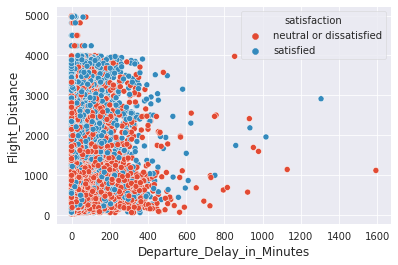

In [ ]:
sns.scatterplot(data=df, y='Flight_Distance',
                x = 'Departure_Delay_in_Minutes',
               hue = 'satisfaction')

Variable continua : Age


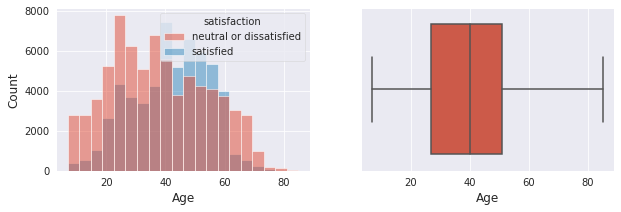

Variable continua : Flight_Distance


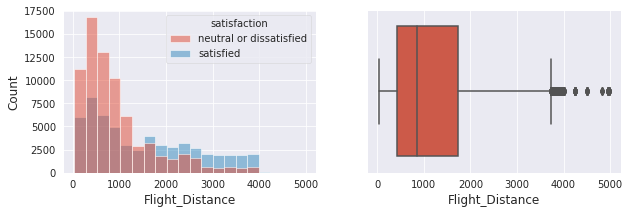

In [ ]:
biplot(df, ['Age', 'Flight_Distance'], 'satisfaction')

In [ ]:
pd.crosstab(index=df['Customer_Type'], columns=df['Class'], normalize='columns')

Class,Business,Eco,Eco Plus
Customer_Type,,,
Loyal Customer,0.851496,0.766177,0.902773
disloyal Customer,0.148504,0.233823,0.097227


In [ ]:
pd.crosstab(index=df['Customer_Type'], columns=df['Type_of_Travel'], normalize='columns')

Type_of_Travel,Business travel,Personal Travel
Customer_Type,,
Loyal Customer,0.737114,0.994998
disloyal Customer,0.262886,0.005002


In [ ]:
pd.crosstab(index=df['Customer_Type'], columns=df['Inflight_wifi_service'], normalize='columns')

Inflight_wifi_service,0,1,2,3,4,5
Customer_Type,,,,,,
Loyal Customer,0.775536,0.834602,0.811448,0.810906,0.807265,0.843062
disloyal Customer,0.224464,0.165398,0.188552,0.189094,0.192735,0.156938


Variable categórica : Gender


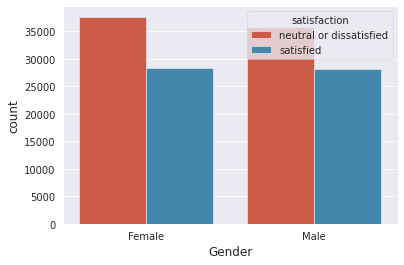

Variable categórica : Customer_Type


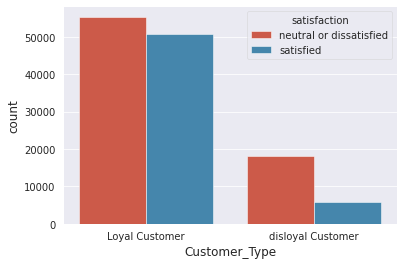

Variable categórica : Type_of_Travel


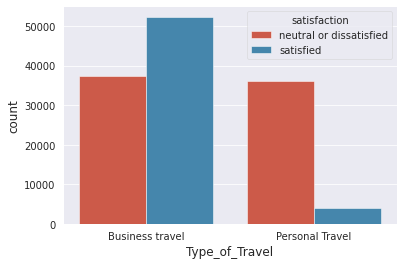

Variable categórica : Class


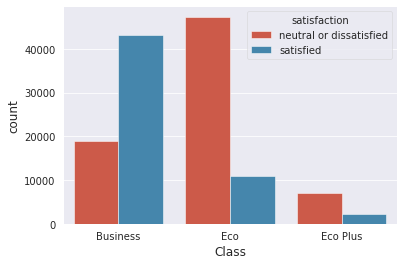

In [ ]:
biplot(df, bin_cols, 'satisfaction')

Variable categórica : Inflight_wifi_service


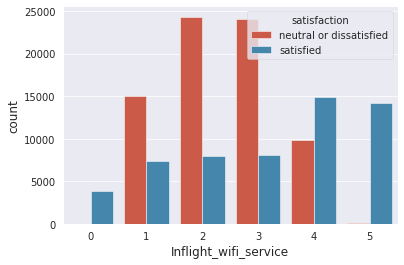

Variable categórica : Departure_Arrival_time_convenient


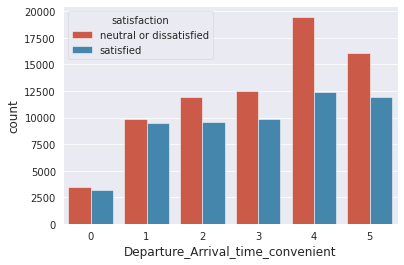

Variable categórica : Ease_of_Online_booking


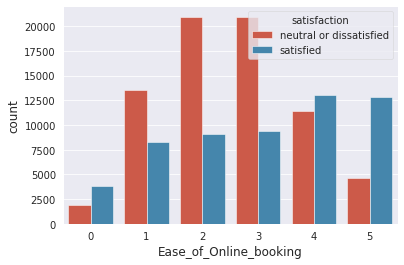

Variable categórica : Gate_location


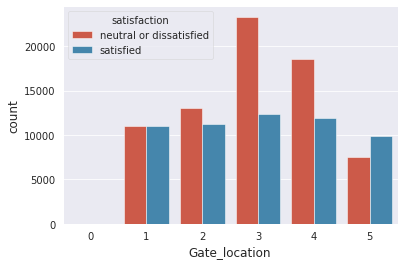

Variable categórica : Food_and_drink


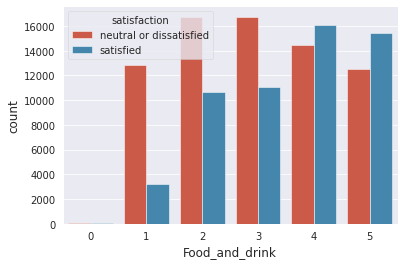

Variable categórica : Online_boarding


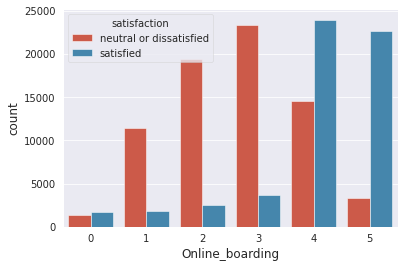

Variable categórica : Seat_comfort


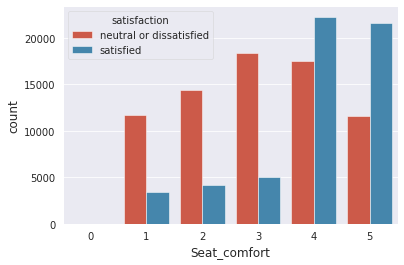

Variable categórica : Inflight_entertainment


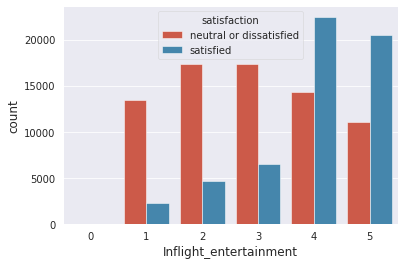

Variable categórica : On_board_service


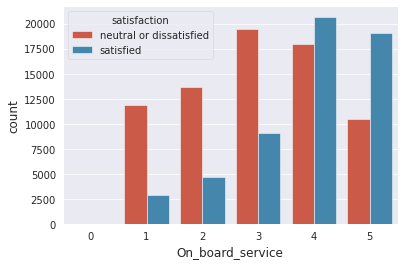

Variable categórica : Leg_room_service


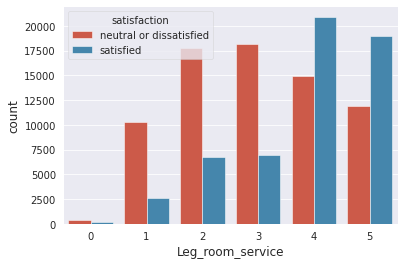

Variable categórica : Baggage_handling


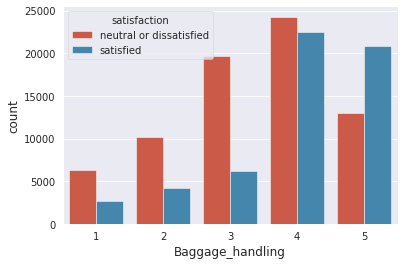

Variable categórica : Checkin_service


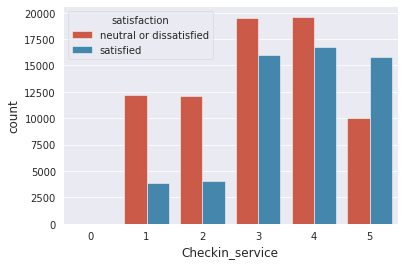

Variable categórica : Inflight_service


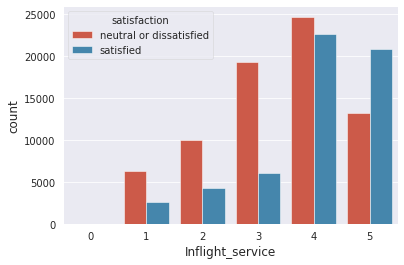

Variable categórica : Cleanliness


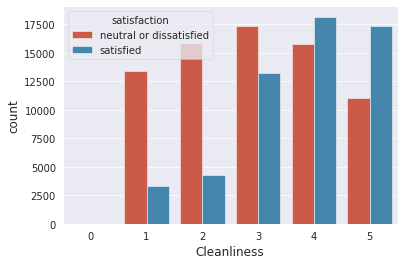

In [ ]:
biplot(df, sat_cols, 'satisfaction')

Conclusiones del análisis gráfico:

- Hay un 56,6% de pasajeros neutrales o insatisfechos y un 43,4% satisfechos. 
- Niveles de las categorías generalmente bien representadas. En sat_cols se encuentran puntuaciones “0”, estas serán equivalentes a NAs.
- Outliers reconocidos en ‘Departure_Delay_in_Minutes’ y ‘Arrival_Delay_in_Minutes. Estos a su vez tienen una gran correlación lineales. Estos retrasos se distribuyen uniformemente sobre ‘Flight_Distance’
- A mayores distancias, mayor posibilidad de cliente satisfecho.
- Por edad, los pasajeros comprendidos entre 40 y 60 años comprenden mayor número de porcentaje de satisfechos que de neutrales/insatisfechos. En los otros rangos de edades ocurre al contrario.
- Hay una clara correlación positiva entre el nivel de las categorías de satisfacción y la probabilidad que un cliente satisfecho, alcanzándose el punto de inflexión en el nivel 4. Esta correlación no se muestra tan claramente en ‘Gate_location’ y ‘Departure_Arrival_Time_Convenient’. 


## 2.3 Solución manual al problema <a id="2.3"></a>

Con los datos obtenidos podríamos definir un modelo, o en este caso “no modelo” de declarar todos los pasajeros como insatisfechos. En este caso se obtendría una especificidad del 56,6% y una sensibilidad del 0%. Podríamos aumentar la exactitud del modelo tomando alguna referencia de los gráficos, por ejemplo, los pasajeros que puntúen ‘Inflight_wifi_service’ con un 5 o pasajeros que vuelen más de 3000km tendrán una predicción de satisfechos. Con estas afirmaciones aumentaríamos algo la sensibilidad sacrificando algo la especificidad, pero este modelo sería más exacto. La idea principal de este trabajo va a rondar esta idea: se van a buscar las variables que mejor puedan definir la satisfacción del pasajero y se van a cuantificar. A continuación, se va a medir el modelo en temas de sensibilidad y especificidad y si la exactitud del modelo no es suficiente, se buscará métodos más complejos que capten relaciones no lineales sacrificando la interpretabilidad del modelo predictivo.

# 3. Preparación de los datos <a id="3"></a>

## 3.1 Depuración de los datos <a id="3.1"></a>


Las principales fases de la depuración de datos son las siuientes:

1. Comprobación de la correcta tipología y rol de las variables
2. Detección de datos atípicos o 'outliers'
3. Tratamiento de datos faltantes
4. Análisis final de relación de variables

In [30]:
df2 = df.copy()
df2 = eliminar_columnas(df2, ['id'])

### 3.1.1 Comprobación de la correcta tipología y rol de las variables:

En el apartado anterior hemos definido la tipología y el rol de las variables pero habrá que tener en cuenta lo siguiente. De las comprobaciones que hay que hacer:
1.	Número de datos faltantes: Variables como más de 50% de NAs han de rechazarse. Lo máximo está en un 5%
2.	Datos faltantes mal codificados: Sat_cols tiene 0 como datos faltantes. Habrá que recodificarlos.
3.	Frecuencia de las variables categóricas: para detectar patrones en las variables input que nos permitan aproximar el valor de la variable objetivo, es imprescindible que todas los niveles (2-5 %). La menor frecuencia es de un 7% así que no habrá que hacer ningún cambio en este aspecto.


Datos faltantes mal codificados: Sat_cols tiene 0 como datos faltantes. Habrá que recodificarlos.

In [31]:
for col in sat_cols:
    df2[col] = df2[col].apply(lambda x : x if x!=0 else np.nan)

Número de datos faltantes: Variables como más de 50% de NAs han de rechazarse. Lo máximo está en un 5%

In [32]:
df2.apply(lambda x: x.isna().sum()/x.count()*100)

Gender                               0.000000
Customer_Type                        0.000000
Age                                  0.000000
Type_of_Travel                       0.000000
Class                                0.000000
Flight_Distance                      0.000000
Inflight_wifi_service                3.108825
Departure_Arrival_time_convenient    5.422934
Ease_of_Online_booking               4.574953
Gate_location                        0.000770
Food_and_drink                       0.101736
Online_boarding                      2.429022
Seat_comfort                         0.000770
Inflight_entertainment               0.013861
On_board_service                     0.003850
Leg_room_service                     0.462555
Baggage_handling                     0.000000
Checkin_service                      0.000770
Inflight_service                     0.003850
Cleanliness                          0.010780
Departure_Delay_in_Minutes           0.000000
Arrival_Delay_in_Minutes          

Frecuencia de las variables categóricas

In [36]:
print(df2.groupby('satisfaction')['satisfaction'].count()/len(df.index)*100)

satisfaction
neutral or dissatisfied    56.553742
satisfied                  43.446258
Name: satisfaction, dtype: float64


In [37]:
for col in cat_cols:
    print(df2.groupby(col)[col].count()/len(df.index)*100)

Gender
Female    50.738374
Male      49.261626
Name: Gender, dtype: float64
Customer_Type
Loyal Customer       81.690791
disloyal Customer    18.309209
Name: Customer_Type, dtype: float64
Type_of_Travel
Business travel    69.058362
Personal Travel    30.941638
Name: Type_of_Travel, dtype: float64
Class
Business    47.859563
Eco         44.894518
Eco Plus     7.245919
Name: Class, dtype: float64
Inflight_wifi_service
1.0    17.191253
2.0    24.884509
3.0    24.780567
4.0    19.075300
5.0    11.053280
Name: Inflight_wifi_service, dtype: float64
Departure_Arrival_time_convenient
1.0    14.943794
2.0    16.579920
3.0    17.229751
4.0    24.545735
5.0    21.556822
Name: Departure_Arrival_time_convenient, dtype: float64
Ease_of_Online_booking
1.0    16.850939
2.0    23.137512
3.0    23.400832
4.0    18.820450
5.0    13.415460
Name: Ease_of_Online_booking, dtype: float64
Gate_location
1.0    16.931783
2.0    18.706498
3.0    27.500000
4.0    23.457037
5.0    13.403911
Name: Gate_location, dty

La menor es de un 7% **OK**

### 3.1.2 Detección de datos atípicos

Los datos atípicos son datos numéricamente distantes del resto, que pueden perturbar los resultados de los modelos que se entrenen posteriormente.
- Si la distribución simétrica: Que superen por 1.5 veces el rango intercuartílico tomando la media con referencia (Estrategia Seis Sigma)
- Si la distribución no es simétrica
y no sean más de un 2-5% de la distribución de esa variable. Una buena forma de ver estos outliers es a través del diagrama de caja y bigotes:



Variable continua : Age


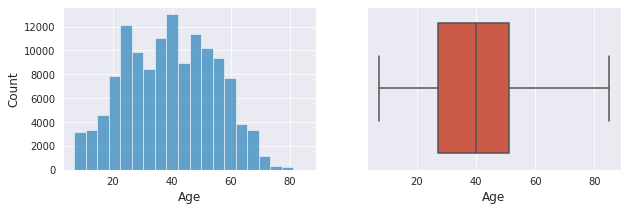

Variable continua : Flight_Distance


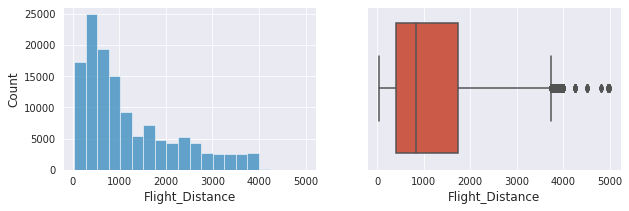

Variable continua : Departure_Delay_in_Minutes


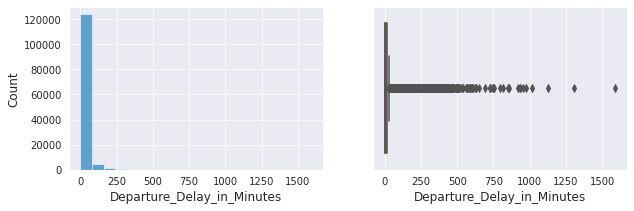

Variable continua : Arrival_Delay_in_Minutes


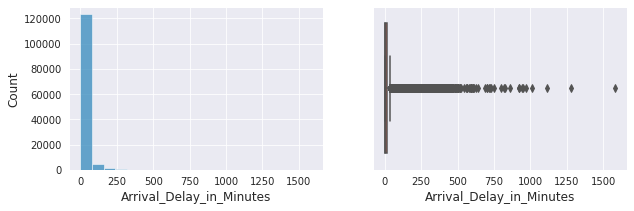

In [38]:
biplot(df2, num_cols)

In [39]:
df3 = df2.copy()
df3 = categorizar(df3)

In [40]:
for col in num_cols:
    print(gestiona_outliers(df[col]))
    print("Skew : "+str(df[col].skew()))

Age
(0.0, 0.0, 0.0)
Skew : -0.003606211745335888
Flight_Distance
(0.0, 0.0, 0.0)
Skew : 1.1081423058353985
Departure_Delay_in_Minutes
(0.0, 1.291191869417924, 1.291191869417924)
Skew : 6.82198031017346
Arrival_Delay_in_Minutes
(0.0, 1.3036057673743309, 1.3036057673743309)
Skew : 6.670124610533305


Los datos atípicos son datos numéricamente distantes del resto, que pueden perturbar los resultados de los modelos que se entrenen posteriormente. podemos observar que las variables ‘Departure_Delay_in_Minutes’ y ‘Arrival_Delay_in_Minutes’ poseen una asimetría palpable (Skew ~ 6,7) y ciertos retrasos que distan de la mayoría de vuelos puntuales. A través de las función gestiona_outliers  se observan que para ambas variables estos outliers corresponden el 1,3% 

In [41]:
out_cols = ['Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']
for col in out_cols:
    df3[col] = gestiona_outliers(df3[col], 'winsor')

Departure_Delay_in_Minutes
Arrival_Delay_in_Minutes


Departure_Delay_in_Minutes


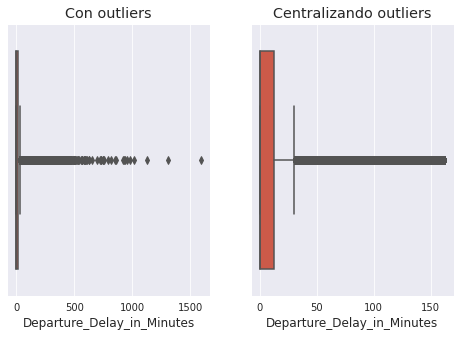

Arrival_Delay_in_Minutes


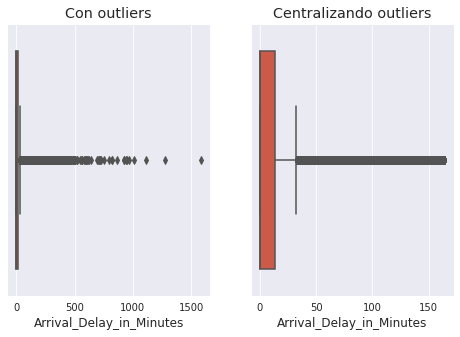

In [42]:
for col in out_cols:
    print(col)
    plt.figure(figsize=(8,5))
    plt.subplot(1,2,1)
    plt.title('Con outliers')
    sns.boxplot(data=df2, x=col)
    plt.subplot(1,2,2)
    plt.title('Centralizando outliers')
    sns.boxplot(data=df3, x=col)
    plt.show()

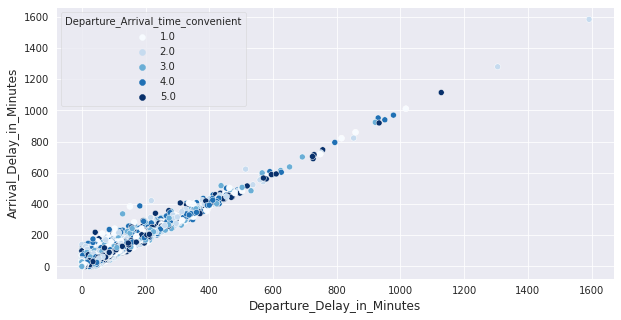

In [43]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df2, 
                x='Departure_Delay_in_Minutes', 
                y='Arrival_Delay_in_Minutes', 
                hue='Departure_Arrival_time_convenient', 
               palette='Blues')
plt.show()

### 3.1.3 Tratamiento de datos faltantes


Los datos faltantes son un problema frecuente en los procesos de minería de datos debido a la general falta de supervisión de la recogida de datos. En este caso podría darse por el fenómeno de NS/NC por falta de uso o conocimiento de ese servicio específico. 

Antes de imputarlos, se muestra la incidencia de los NA.

In [44]:
df4 = df3.copy()

In [45]:
df4.apply(lambda x: x.isna().sum()/x.count()*100)

Gender                               0.000000
Customer_Type                        0.000000
Age                                  0.000000
Type_of_Travel                       0.000000
Class                                0.000000
Flight_Distance                      0.000000
Inflight_wifi_service                3.108825
Departure_Arrival_time_convenient    5.422934
Ease_of_Online_booking               4.574953
Gate_location                        0.000770
Food_and_drink                       0.101736
Online_boarding                      2.429022
Seat_comfort                         0.000770
Inflight_entertainment               0.013861
On_board_service                     0.003850
Leg_room_service                     0.462555
Baggage_handling                     0.000000
Checkin_service                      0.000770
Inflight_service                     0.003850
Cleanliness                          0.010780
Departure_Delay_in_Minutes           0.000000
Arrival_Delay_in_Minutes          

Respecto a las sat_cols hay entre 2-5% de NAs en ‘Inflight_wifi_service’, ‘Departure_Arrival_time_convenient’, ‘Ease_of_Online_booking’ y ‘Online_boarding’. Luego habrá otras 8 variables con NAs rondando a poco más del 0%. Dado el volumen de las observaciones y el poco número de valores nulos, se ha optado por la técnica de cambiar los nulos por la moda de cada variable, mientras que para ‘Arrival_Delay_in_minutes’ se ha optado por colocar el valor de retraso en salida para estos nulos en llegadas. 

In [46]:
#Proporción de missings por observación (como una nueva columna del dataset)
df4['prop_missings'] = df4.apply(lambda x: x.isna().sum()/x.count()*100,axis=1)

# Valoramos distribución
df4.prop_missings.describe()

count    129880.000000
mean          0.770166
std           2.986210
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          21.052632
Name: prop_missings, dtype: float64

In [47]:
df4.groupby('prop_missings')['prop_missings'].count()/len(df4.index)*100

prop_missings
0.000000     91.780105
4.545455      3.770403
9.523810      1.892516
15.000000     1.978750
21.052632     0.578226
Name: prop_missings, dtype: float64

In [48]:
df4['hasNA'] = df4['prop_missings'].apply(lambda x: 0 if x==0 else 1)

In [49]:
df4 = eliminar_columnas(df4, ['prop_missings'])

Dos Estrategias: Para las categóricas --> KNNImputer #tiempo de imputación largo
Para la ArrivalDelay --> DepartureDelay

Variable categórica : Inflight_wifi_service
Variable categórica escalada: Inflight_wifi_service


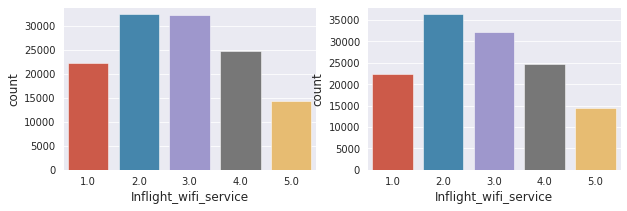

Variable categórica : Departure_Arrival_time_convenient
Variable categórica escalada: Departure_Arrival_time_convenient


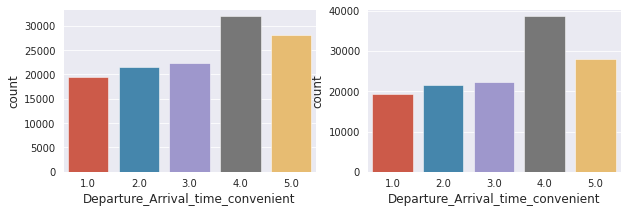

Variable categórica : Ease_of_Online_booking
Variable categórica escalada: Ease_of_Online_booking


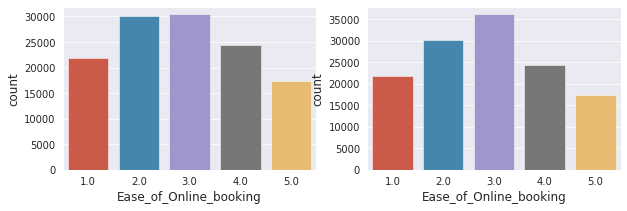

Variable categórica : Gate_location
Variable categórica escalada: Gate_location


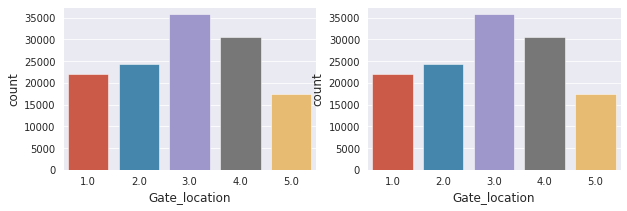

Variable categórica : Food_and_drink
Variable categórica escalada: Food_and_drink


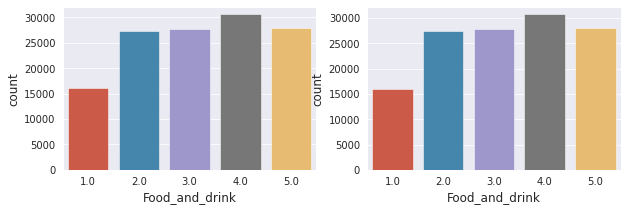

Variable categórica : Online_boarding
Variable categórica escalada: Online_boarding


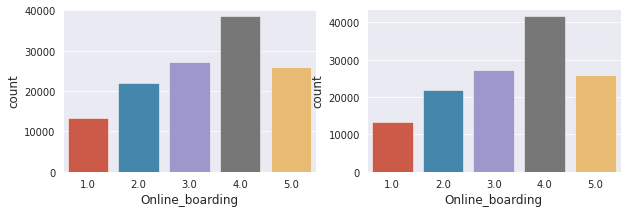

Variable categórica : Seat_comfort
Variable categórica escalada: Seat_comfort


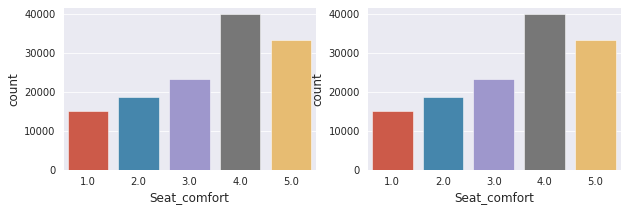

Variable categórica : Inflight_entertainment
Variable categórica escalada: Inflight_entertainment


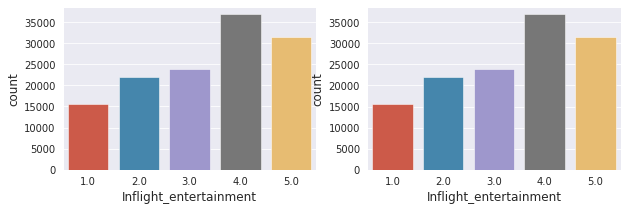

Variable categórica : On_board_service
Variable categórica escalada: On_board_service


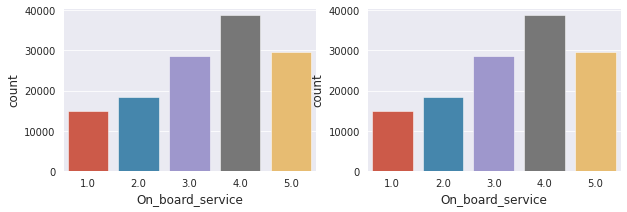

Variable categórica : Leg_room_service
Variable categórica escalada: Leg_room_service


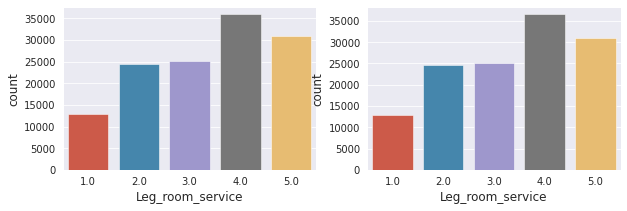

Variable categórica : Baggage_handling
Variable categórica escalada: Baggage_handling


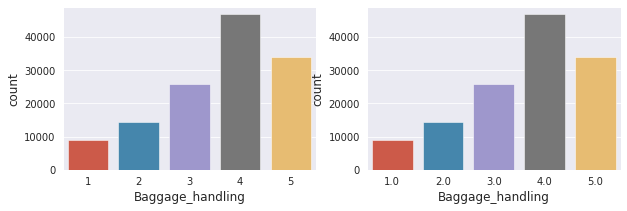

Variable categórica : Checkin_service
Variable categórica escalada: Checkin_service


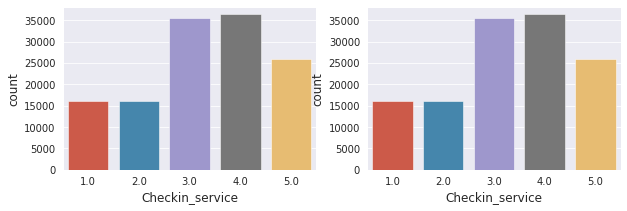

Variable categórica : Inflight_service
Variable categórica escalada: Inflight_service


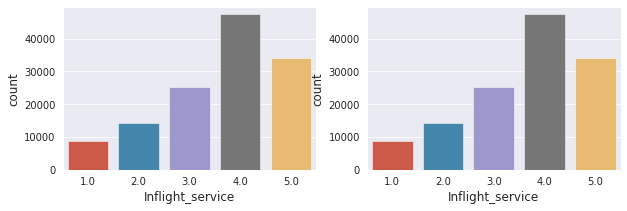

Variable categórica : Cleanliness
Variable categórica escalada: Cleanliness


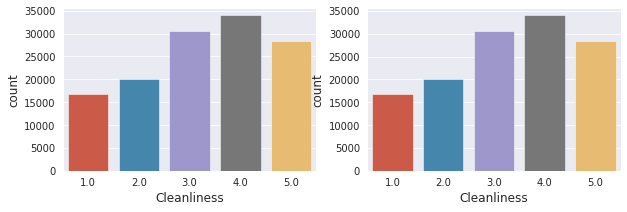

In [50]:
df4 = imputar_NA(df4, sat_cols, SimpleImputer(strategy='most_frequent'))

In [51]:
df4.loc[df['Arrival_Delay_in_Minutes'].isna(), 'Arrival_Delay_in_Minutes'] = df4.loc[df['Arrival_Delay_in_Minutes'].isna(), 
                                                                                     'Departure_Delay_in_Minutes']

In [52]:
df4.isna().sum()

Gender                               0
Customer_Type                        0
Age                                  0
Type_of_Travel                       0
Class                                0
Flight_Distance                      0
Inflight_wifi_service                0
Departure_Arrival_time_convenient    0
Ease_of_Online_booking               0
Gate_location                        0
Food_and_drink                       0
Online_boarding                      0
Seat_comfort                         0
Inflight_entertainment               0
On_board_service                     0
Leg_room_service                     0
Baggage_handling                     0
Checkin_service                      0
Inflight_service                     0
Cleanliness                          0
Departure_Delay_in_Minutes           0
Arrival_Delay_in_Minutes             0
satisfaction                         0
hasNA                                0
dtype: int64

### 3.1.4 Relación entre las variables

Una vez los datos están depurados, se ha analizado la relación existente entre las variables input y la objetivo, para determinar la utilidad predictiva de las primeras. Para ello primero se expone la matriz de correlaciones:

In [53]:
df5 = df4.copy()
df5 = categorizar(df5)

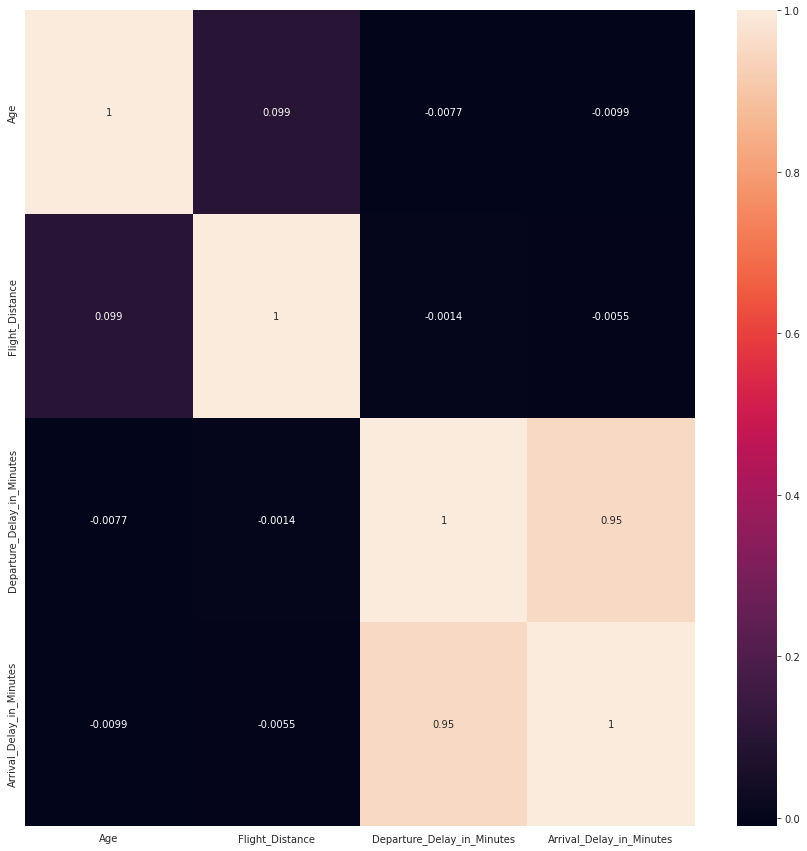

In [54]:
"""Correlación"""
plt.figure(figsize=(15,15))
sns.heatmap(df5.corr(), annot=True)
plt.show()

El 0,95 de correlación lineal entre los retrasos provoca que haya que reducir la dimensión para evitar problemas de linealidad. En este caso se ha optado por incluir una variable ‘Average_Delay_in_Minutes’ con la media de las dos y eliminar éstas. 

In [55]:
df5['Average_Delay_in_Minutes'] = (df5['Departure_Delay_in_Minutes'] + 
                                  df5['Arrival_Delay_in_Minutes']) / 2

In [56]:
print(df5['Average_Delay_in_Minutes'].skew())
df5['Average_Delay_in_Minutes'] = gestiona_outliers(df5['Average_Delay_in_Minutes'], 'winsor')
print(df5['Average_Delay_in_Minutes'].skew())

3.1997424702044306
Average_Delay_in_Minutes
3.032207837319107


In [57]:
df5 = eliminar_columnas(df5, ['Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes'])

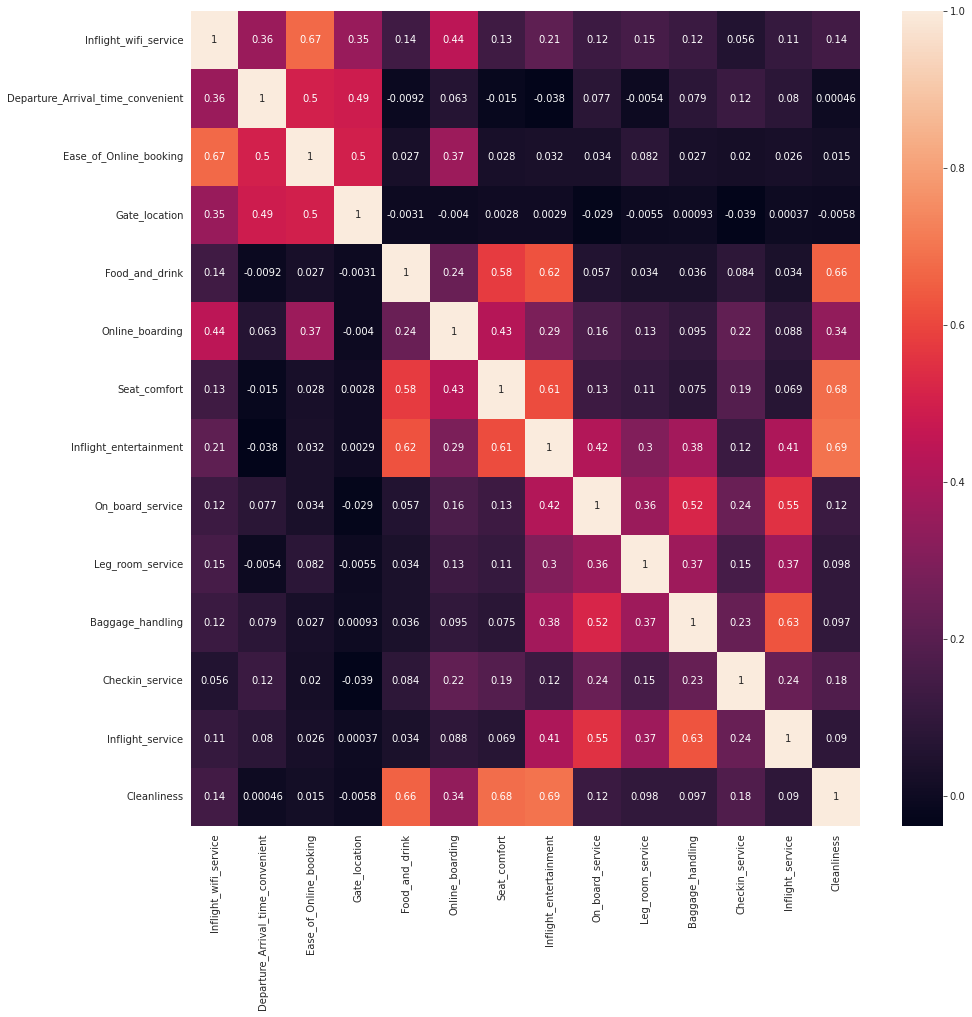

In [58]:
"""Correlación"""
plt.figure(figsize=(15,15))
sns.heatmap(df4[sat_cols].corr(), annot=True)
plt.show()

Respecto a las sat_cols se puede atisvar una relación entre los procesos aeroportuarios como la relación entre ‘Gate_location’ y ‘Departure_Arrival_time_convenient’ y entre el servicio a bordo ‘Food_and_drink’ y ‘Seat_comfort’
Respecto a la variable respuesta, para determinar la potencia predictiva se va utilizar la V de Cramer como métrica. Para ello se han generado dos variables aleatorias con nula capacidad predictiva para comparar con las variables input. 


In [63]:
df5['random'] = np.random.uniform(0,1,size=df3.shape[0])
df5['random2'] = np.random.uniform(0,1,size=df3.shape[0])

In [64]:
features = eliminar_columnas(df5, ['satisfaction'])
target = df5.satisfaction

In [65]:
tablaCramer = pd.DataFrame(features.apply(lambda x: cramers_v(x,target)),columns=['VCramer'])
tablaCramer.sort_values(by=['VCramer'], ascending=False)

,VCramer
Online_boarding,0.617298
Class,0.503347
Inflight_wifi_service,0.463400
Type_of_Travel,0.449861
Inflight_entertainment,0.421221
Seat_comfort,0.387849
Leg_room_service,0.340570
On_board_service,0.332243
Cleanliness,0.315553
Flight_Distance,0.296241


Lo que se observa de esta métrica es que ninguna variable tiene menor relación que las valores aleatorios, pero es posible que variables como ‘Gender’ y ‘hasNA’ podrían ser eliminadas para reducir la dimensión en los modelos posteriores al no mostrar relación con la respuesta. También se percibe una falta de relación entre el retraso y la satisfacción del pasajero. Por otro lado, el ‘Online_boarding’ y la ‘Class’ tienen gran potencia predictiva. 

## 3.2 Transformación de variables<a id="3.2"></a>

Una tarea fundamental en la preparación de los datos es la codificación de las variables categóricas. Existen herramientas en Python como LabelEncoder de sklearn, get_dummies de pandas o la librería patsy que construye matrices de diseño codificando las variables categóricas. En este trabajo se han utilizado las tres mencionadas según los requerimientos del problema.

In [73]:
df6 = df5.copy()

In [74]:
encoder = LabelEncoder()
df6.satisfaction = encoder.fit_transform(df6.satisfaction)
df6 = categorizar(df6)

In [75]:
features = eliminar_columnas(df6, ['satisfaction'])
target = df6.satisfaction

En el apartado de las numéricas se ha optado por escalar los datos de la manera “estándar” restando la media y dividiendo por la desviación típica. También se han analizado las transformaciones típicas (log, exp, sqrt, square, elevado a cuatro y raiz cuarta) de las numéricas para conocer si alguna transformación supera en V de Cramer a la original. 

In [76]:
no_Random = eliminar_columnas(features, ['random',  'random2'])

In [77]:
no_Random_Num = no_Random.select_dtypes(include=np.number)
cols = no_Random_Num.columns


In [78]:
dicc = {}
for col in cols:
    transf_cramer = mejorTransf(no_Random_Num, col, target, tipo='cramer', graf=False)
    transf_cramer_names = mejorTransf(no_Random_Num, col, target,tipo='cramer', name=True)
    dicc[transf_cramer_names] = transf_cramer

transf = pd.DataFrame(dicc)
transf.columns

Index(['Age_sqrt', 'Flight_Distance_exp', 'Average_Delay_in_Minutes_log'], dtype='object')

StandardScaler en columnas numéricas

In [79]:
features[cols] = escalar(features, ['Age', 'Flight_Distance', 'Average_Delay_in_Minutes'])

In [80]:
features_transf = features.join(transf)

In [81]:
features_transf.columns

Index(['Gender', 'Customer_Type', 'Age', 'Type_of_Travel', 'Class',
       'Flight_Distance', 'Inflight_wifi_service',
       'Departure_Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On_board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'hasNA', 'Average_Delay_in_Minutes', 'random', 'random2',
       'Age_sqrt', 'Flight_Distance_exp', 'Average_Delay_in_Minutes_log'],
      dtype='object')

Guardamos los datos depurados y transformados. En este notebook hay varios de escritura y lectura por si el trabajo se quisiera hacer a trozos

In [84]:
data_tot = features_transf.join(target.astype('int64'))

In [83]:
"""

path = '/content/drive/My Drive/passenger_satisfaction_clean.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  data_tot.to_csv(f)
"""

"\n\npath = '/content/drive/My Drive/passenger_satisfaction_clean.csv'\nwith open(path, 'w', encoding = 'utf-8-sig') as f:\n  data_tot.to_csv(f)\n"

In [ ]:
"""
path = '/content/drive/My Drive/passenger_satisfaction_clean.csv'
with open(path, 'r', encoding = 'utf-8-sig') as f:
  df_clean = pd.read_csv(f, index_col=0)

data_tot = df_clean
"""

## 3.3 Selección de variables<a id="3.3"></a>

En futuras operaciones se va a utilizar las variables input codificadas y sin codificar, por eso se ha creado dos dataset con y sin esta operación

In [85]:
data_tot = categorizar(data_tot)
y = data_tot.satisfaction

In [86]:
X = eliminar_columnas(data_tot, ['satisfaction'])
X.shape

(129880, 27)

In [87]:
X_dum = pd.get_dummies(X, drop_first=True)
X_dum.shape

(129880, 70)

### 3.3.1 Selección de método de evaluación

El gran volumen de variables ha provocado que se plantee la posibilidad de reducir la dimensión a través de la selección de variables sin perder potencia predictiva. Esta selección se llevará a cabo con el dataset anteriormente definido y a través de la regresión logístico. Como estudio previo, se han analizado los distintos modelos de evaluación con validación cruzada, validación cruzada repetida y entrenamiento-test. 

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=seed)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(103904, 70)
(103904,)
(25976, 70)
(25976,)


Media scoring0.9211579919926086
Desviación típica0.0012105478291982597


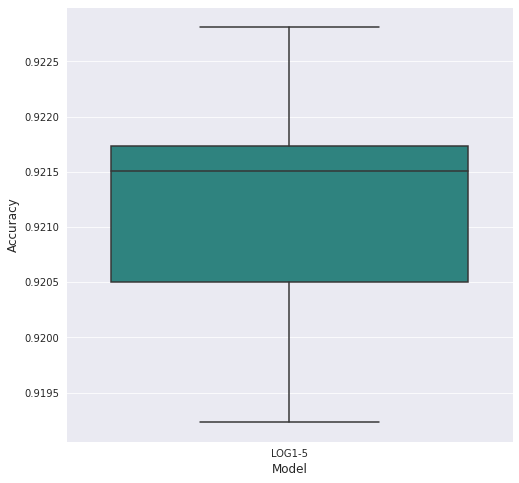

In [ ]:
#Validación cruzada
model_df0 = cross_val_model(X_dum, y, "LOG1-5",
                            pd.DataFrame({
                        'Model': pd.Series(dtype='str'),
                        'Accuracy': pd.Series(dtype='float')
                        }))

Media scoring 0.921078431372549
Desviación típica 0.00167713372666682


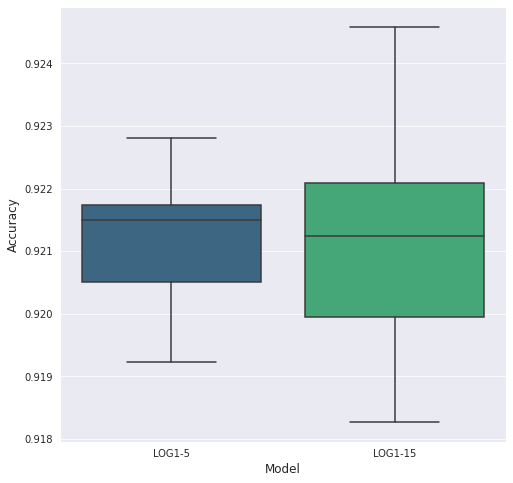

In [ ]:
#Validación cruzada repetida (5 divisiones y 3 repeticiones)
model_df01 = cross_val_model(X_dum, y, "LOG1-15", model_df0, True)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
result = model.score(X_test, y_test)
score1 = ["LOG1-TRTST", result]
model_df02 = model_df01.copy()

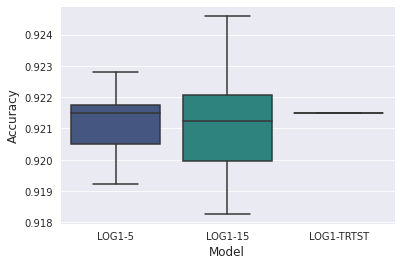

In [ ]:
model_df02.loc[len(model_df02)] = score1
sns.boxplot(
            x=model_df02.columns[0],
            y=model_df02.columns[1],
            data=model_df02, 
            palette='viridis')
plt.show()

**1. Guardamos el primer modelo con todas las variables con validación cruzada repetida**

In [ ]:
model_df03 = model_df02.copy()

In [ ]:
model_df03 = model_df03.loc[model_df03.Model == "LOG1-15"].reset_index()
model_df03 = eliminar_columnas(model_df03, ['index'])

In [ ]:
"""
path = '/content/drive/My Drive/model_df03.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  model_df03.to_csv(f)

"""

In [89]:
"""
path = '/content/drive/My Drive/model_df03.csv'
with open(path, 'r', encoding = 'utf-8-sig') as f:
  model_val_cr = pd.read_csv(f, index_col=0)

model_df03 = model_val_cr
"""

### 3.3.2 Modelos manuales

Se han evaluado seis modelos manuales siguiendo una metodología backward. Partiendo del set total de variables, se ha tomado de referencia la Tabla de Cramer, para ir eliminando variables con menor capacidad predictiva e ir evaluando el modelo en general. Al tener una cantidad considerable de variables, se ha optado por usar métodos automáticos de selección de variables.

**2. Todas menos aleatorias**

In [ ]:
X1 = eliminar_columnas(X_dum, ['random', 'random2'])
model_df1 = model_df03.copy()

In [ ]:
X1.shape

(129880, 68)

Media scoring 0.9211579919926087
Desviación típica 0.0016672981662060754


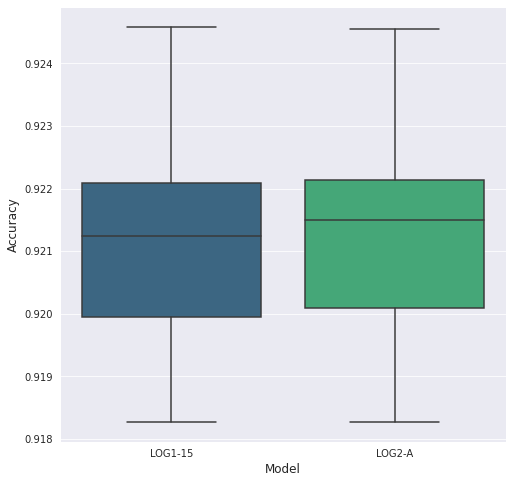

In [ ]:
model_df1 = cross_val_model(X1, y, "LOG2-A", model_df03, True)

La eliminación de las variables random reduce ligeramente el sesgo. Ahora tomamos el set de variables originales.

**3. Variables en 2 - Var. Num. Trasnf.**

In [ ]:
X11 = eliminar_columnas(X1, ['Age_sqrt',
       'Flight_Distance_exp', 'Average_Delay_in_Minutes_log'])
model_df11 = model_df1.copy()

Media scoring 0.9205985011805772
Desviación típica 0.0016525287320945919


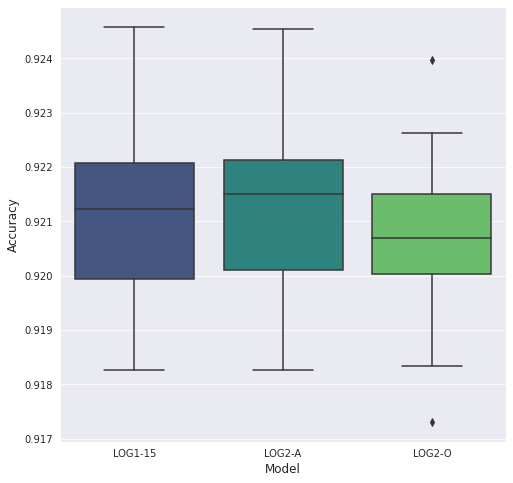

In [ ]:
model_df11 = cross_val_model(X11, y, "LOG2-O", model_df1, True)

Se sesga algo más pero se reduce bastante la variabilidad. Ahora si tomamos las transformadas y no las originales numéricas.

**4. Variables en 2 - Var. Num. Original**

In [ ]:
X12 = eliminar_columnas(X1, ['Age',
       'Flight_Distance', 'Average_Delay_in_Minutes'])
model_df12 = model_df11.copy()

Media scoring 0.9208885124730521
Desviación típica 0.0016274749110705654


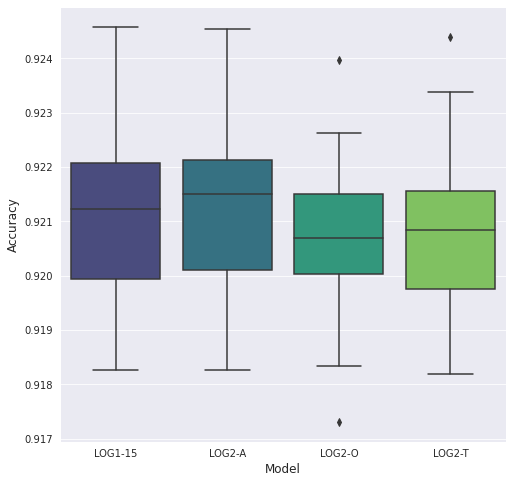

In [ ]:
model_df12 = cross_val_model(X12, y, "LOG2-T", model_df11, True)

Da algo más de variabilidad que el set con variables originales. Ahora vamos a quitar las variables que estaban en las últimas posiciones de V_de_cramer: 'hasNA' y 'Gender' (aquí tienen una nomenclatura distina porque hemos usado get_dummies). 

**5. Variables en 3 - Gender - hasNA**

In [ ]:
X2 = eliminar_columnas(X11, ['Gender_Male', 'hasNA_1'])
model_df2 = model_df12.copy()

Media scoring 0.9179499024740788
Desviación típica 0.0015721183685533436


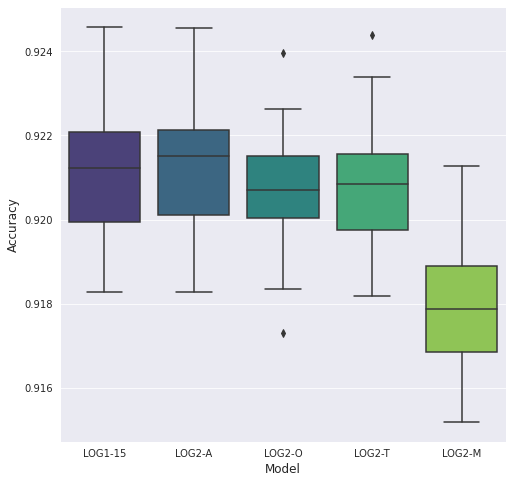

In [ ]:
model_df2 = cross_val_model(X2, y, "LOG2-M", model_df12, True)

En general con esta reducción se pierde dos puntos porcentuales de accuracy. También se ha comprobado eliminando solo el género. 

**6. Variables en 3 - Gender**

In [ ]:
X21 = eliminar_columnas(X11, ['Gender_Male'])
model_df21 = model_df2.copy()

Media scoring 0.9205754029360437
Desviación típica 0.001648997457822543


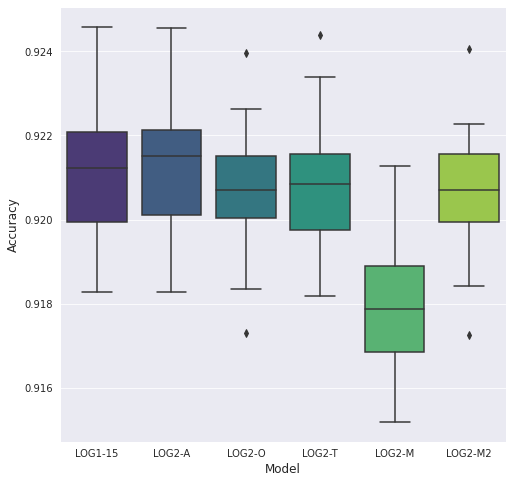

In [ ]:
model_df21 = cross_val_model(X21, y, "LOG2-M2", model_df2, True)

En este caso sí obtendríamos un modelo similar a los anteriores, habiendo eliminado esta variable

In [ ]:
"""
path = '/content/drive/My Drive/model_manual.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  model_df21.to_csv(f)
"""

In [90]:
"""
path = '/content/drive/My Drive/model_manual.csv'
with open(path, 'r', encoding = 'utf-8-sig') as f:
  model_manual = pd.read_csv(f, index_col=0)

model_df21 = model_manual
"""

### 3.3.3 Modelos automáticos

La selección automática de variables aleatorias viene dada por el estadístico de información mutua que presenta buen comportamiento para input de variables categóricas en el problema de regresión. https://machinelearningmastery.com/feature-selection-with-categorical-data/. La información mutua, del es la aplicación de la ganancia de información (utilizada normalmente en la construcción de árboles de decisión) a la selección de características y mide la reducción de la incertidumbre para una variable dado un valor conocido de la otra variable. 

Para ello se ha definido la función select_features que combina la función SelectKBest que tiene por función de scoring, la información mutua de todas las variables. Una vez realizada la función nos sale un score total de 1,45 obtenida por la suma de todas las variables.


En este caso, se han filtrado los resultados de estas variables por scoring: selección de puntuaciones distintos de 0 (FS-0), selección de puntuaciones mayor que 0,05 (FS-1) y selección de puntuaciones por encima de 0,1 (FS-2) y a partir de este último se ha creado (FS-3) en el que se han eliminado manualmente dos variables numéricas. 

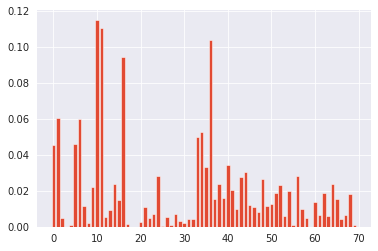

In [93]:
#Barplot del scoring de las 70 variables
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
 # what are scores for the features
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [94]:
#Creamos un dataframe con scores y variable
scores = pd.DataFrame({'Feature' : X_train.columns,
              'Score' : fs.scores_})

In [95]:
scores.Score.sum()

1.4371562926527013

Una vez realizada la función nos sale un score total de 1,44 y se han filtrado por scoring: selección de puntuaciones distintos de 0, selección de puntuaciones mayor que 0,005 y selección de puntuaciones por encima de 0,01 

#### 3.3.3.1 Filtrado de variables con score 0

In [96]:
scores0 = scores.loc[scores.Score>0]

In [97]:
X30 = X_dum[list(scores0.Feature)]
X30.shape

(129880, 66)

In [ ]:
model_df30 = model_df21.copy()

Media scoring 0.9202674263422648
Desviación típica 0.001595214375908064


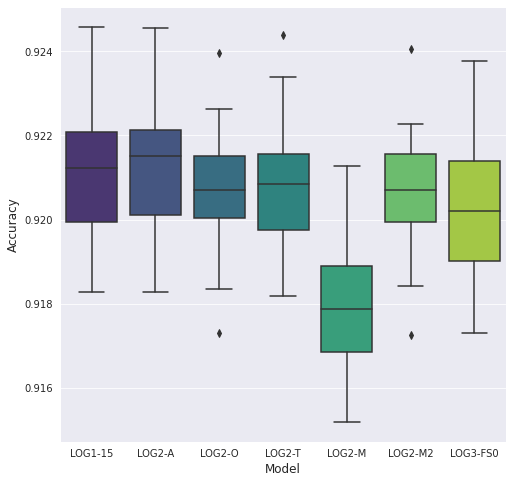

In [ ]:
model_df30 = cross_val_model(X30, y, "LOG3-FS0", model_df30, True)

#### 3.3.3.2 Filtrado de variables con score > 0.005

In [ ]:
scores1 = scores.loc[scores.Score>0.005]

In [ ]:
X31 = X_dum[list(scores1.Feature)]
X31.shape

(129880, 49)

In [ ]:
model_df31 = model_df30.copy()

Media scoring 0.9159403551996717
Desviación típica 0.0013422818296832926


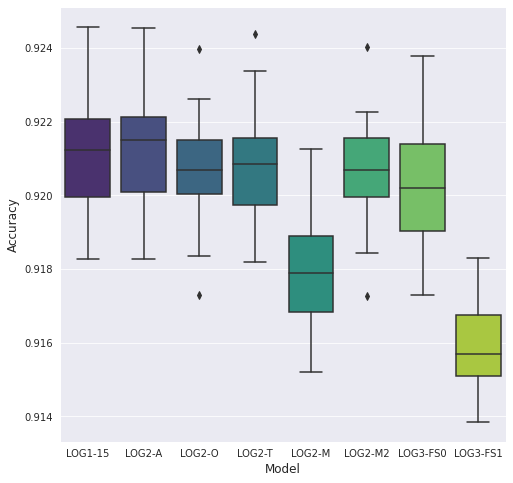

In [ ]:
model_df31 = cross_val_model(X31, y, "LOG3-FS1", model_df31, True)

#### 3.3.3.3 Filtrado de variables con score >0.01

In [ ]:
scores2 = scores.loc[scores.Score>0.01]

In [ ]:
X32 = X_dum[list(scores2.Feature)]
X32.shape

(129880, 37)

In [ ]:
model_df32 = model_df31.copy()

Media scoring 0.9152910378811213
Desviación típica 0.0015262071086112748


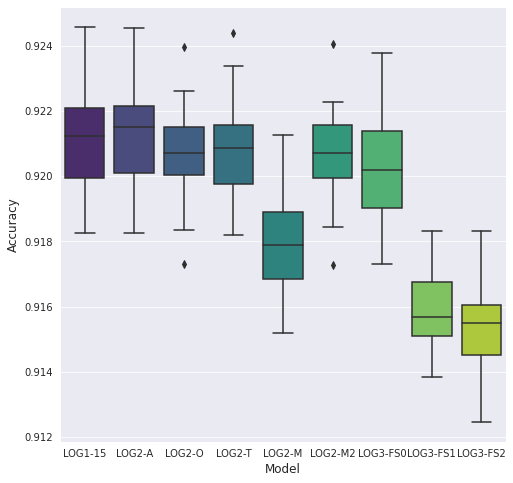

In [ ]:
model_df32 = cross_val_model(X32, y, "LOG3-FS2", model_df32, True)

In [ ]:
model_log_tot = model_df32.copy()

In [ ]:
"""
path = '/content/drive/My Drive/model_log.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  model_log_tot.to_csv(f)
"""

In [91]:
"""
path = '/content/drive/My Drive/model_log.csv'
with open(path, 'r', encoding = 'utf-8-sig') as f:
  model_final = pd.read_csv(f, index_col=0)

model_log_tot = model_final
"""

Generamos una tabla final con los resultados del modelo

In [92]:
tablaFinal = model_log_tot.groupby('Model')['Accuracy'].agg(mean='mean', std='std')

In [ ]:
"""Numero de variables"""
conj_X = [X_dum, X1, X11, X12, X2,
          X21, X30, X31, X32]
var_num = []
for var in conj_X:
  var_num.append(var.shape[1])

In [ ]:
tablaFinal["N_variables"] = var_num

In [ ]:
tablaFinal

,mean,std,N_variables
Model,,,
LOG1-15,0.921078,0.001736,70
LOG2-A,0.921158,0.001726,68
LOG2-M,0.917950,0.001627,65
LOG2-M2,0.920575,0.001707,65
LOG2-O,0.920599,0.001711,63
LOG2-T,0.920889,0.001685,64
LOG3-FS0,0.920267,0.001651,64
LOG3-FS1,0.915940,0.001389,49
LOG3-FS2,0.915291,0.001580,37


Se observa que el primer modelo automático tiene precisión parecida a los modelos manuales, pero con algo más de variabilidad. A continuación, los modelos siguientes pierden medio punto porcentual, pero con una reducción considerable de variables

### 3.3.4 Modelo escogido

Vamos a probar a analizar los resultados de la selección de variables automática de 37 variables. Primero, se guardan las columnas en un nueva variable y se crea el DataFrame

In [ ]:
list_col = []
for i in scores2.Feature:
  list_col.append(i)

In [ ]:
X_auto = X_dum[list_col]

In [ ]:
df_sel_ft = X_auto.join(y.astype('int64'))

Para intrepretar los resultados es necesario cambiar la nomenclatura de las columnas (la librería patsy necesita una fórmula y matriz de diseño) Así que carácteres "+" "-" o números pueden alterar los resultados

In [ ]:
df_sel_ft = renombrar(df_sel_ft, "\s|-|/|.0")

In [ ]:
ols_auto = ols_formula(df_sel_ft, 'satisfaction')

In [ ]:
modeloAuto = logit(ols_auto, data=df_sel_ft).fit()
modeloAuto.summary()

Optimization terminated successfully.
         Current function value: 0.225720
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           satisfaction   No. Observations:               129880
Model:                          Logit   Df Residuals:                   129842
Method:                           MLE   Df Model:                           37
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                  0.6703
Time:                        16:13:57   Log-Likelihood:                -29316.
converged:                       True   LL-Null:                       -88907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.2863      0.503     -6.538      0.000      -4.272      -2.301
Age                                -0.4632      0.060     -7.778      0.000      -0.580      -0.346
Flight_Distance                     0.0935      0.101      0.927      0.354      -0.104       0.291
Age_sqrt                            2.1970      0.360      6.103      0.000       1.491       2.903
Flight_Distance_exp                -0.0740      0.345     -0.214      0.830      -0.751       0.603
Average_Delay_in_Minutes_log       -0.0808      0.003    -25.640      0.000      -0.087      -0.075
Customer_Type_disloyal_Customer    -2.6528      0.035    -76.003      0.000      -2.721      -2.584
Type_of_Travel_Personal_Travel     -3.9079      0.038   -103.216      0.000      -3.982      -3.834
Class_Eco                          -0.4693      0.026    -17.777      0.000      -0.521      -0.418
Inflight_wifi_service_3__          -0.6932      0.032    -21.653      0.000      -0.756      -0.630
Inflight_wifi_service_4__           0.5615      0.029     19.314      0.000       0.505       0.619
Inflight_wifi_service_5__           6.2180      0.109     56.915      0.000       6.004       6.432
Ease_of_Online_booking_5__         -0.8198      0.039    -20.815      0.000      -0.897      -0.743
Online_boarding_2__                -0.1265      0.048     -2.629      0.009      -0.221      -0.032
Online_boarding_3__                 0.2157      0.048      4.464      0.000       0.121       0.310
Online_boarding_4__                 2.2624      0.044     51.094      0.000       2.176       2.349
Online_boarding_5__                 3.1476      0.054     58.677      0.000       3.042       3.253
Seat_comfort_2__                   -0.2578      0.053     -4.829      0.000      -0.362      -0.153
Seat_comfort_3__                   -1.4341      0.049    -29.202      0.000      -1.530      -1.338
Seat_comfort_4__                   -0.8231      0.047    -17.419      0.000      -0.916      -0.730
Seat_comfort_5__                   -0.1015      0.052     -1.964      0.050      -0.203      -0.000
Inflight_entertainment_2__          0.7918      0.057     13.804      0.000       0.679       0.904
Inflight_entertainment_3__          1.8052      0.051     35.468      0.000       1.705       1.905
Inflight_entertainment_4__          1.3184      0.048     27.211      0.000       1.223       1.413
Inflight_entertainment_5__          0.6473      0.060     10.842      0.000       0.530       0.764
On_board_service_2__               -0.4095      0.041    -10.061      0.000      -0.489      -0.330
On_board_service_4__                0.2511      0.031      8.012      0.000       0.190       0.313
On_board_service_5__                0.6671      0.037     18.131      0.000       0.595       0.739
Leg_room_service_2__                0.0369      0.033      1.119      0.263      -0.028       0.102
Leg_room_service_4__                0.843

In [ ]:
np.exp(modeloAuto.params)

Intercept                            0.037391
Age                                  0.629256
Flight_Distance                      1.098005
Age_sqrt                             8.997837
Flight_Distance_exp                  0.928645
Average_Delay_in_Minutes_log         0.922383
Customer_Type_disloyal_Customer      0.070454
Type_of_Travel_Personal_Travel       0.020083
Class_Eco                            0.625433
Inflight_wifi_service_3__            0.499970
Inflight_wifi_service_4__            1.753340
Inflight_wifi_service_5__          501.710096
Ease_of_Online_booking_5__           0.440510
Online_boarding_2__                  0.881208
Online_boarding_3__                  1.240702
Online_boarding_4__                  9.606214
Online_boarding_5__                 23.281036
Seat_comfort_2__                     0.772738
Seat_comfort_3__                     0.238339
Seat_comfort_4__                     0.439069
Seat_comfort_5__                     0.903455
Inflight_entertainment_2__        

**Vemos que habría que interpretar en el modelo tanto Age como Age_sqrt y Flight_Distance y Flight_Distance_exp. Con motivos de simplificación e explicabilidad, se va eliminar las transformadas de estas variables**

In [ ]:
X33 = eliminar_columnas(X32, ['Age_sqrt', 'Flight_Distance_exp'])
X33.shape

(129880, 35)

In [ ]:
model_log_tot_F = model_log_tot.copy()

Media scoring 0.9154321938199362
Desviación típica 0.0014419688278700868


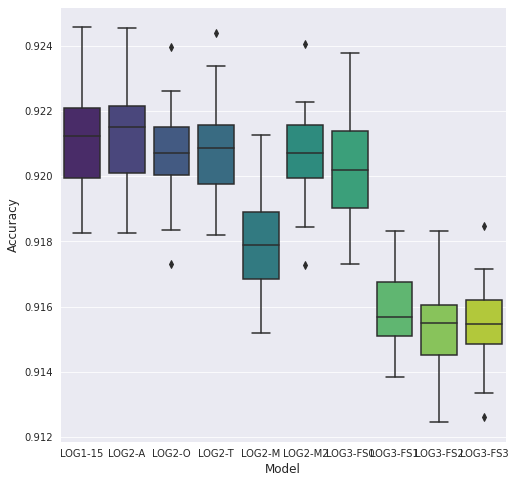

In [ ]:
model_log_tot_F = cross_val_model(X33, y, "LOG3-FS3", model_log_tot_F, True)

Vemos que reduciendo 2 variables el modelo obtiene menor variabilidad. Obtenemos la tabla final.

In [ ]:
aux = model_log_tot_F.groupby('Model')['Accuracy'] \
    .agg(mean='mean', std='std').tail(1)

In [ ]:
aux['N_variables'] = X33.shape[1]

In [ ]:
tablaFinal = pd.concat([tablaFinal, aux])

In [ ]:
tablaFinal

,mean,std,N_variables
Model,,,
LOG1-15,0.921078,0.001736,70
LOG2-A,0.921158,0.001726,68
LOG2-M,0.917950,0.001627,65
LOG2-M2,0.920575,0.001707,65
LOG2-O,0.920599,0.001711,63
LOG2-T,0.920889,0.001685,64
LOG3-FS0,0.920267,0.001651,64
LOG3-FS1,0.915940,0.001389,49
LOG3-FS2,0.915291,0.001580,37


**El set que ha escogido finalmente es el modelo FS3 que combina una reducción de variables dada por el estadístico de información mutua y una estrategia de mayor interpretabilidad quitando las variables numéricas que aparecían en versión original y transformada (‘Age’ y ‘Flight_Distance’)**

In [ ]:
model_acc = model_log_tot_F.loc[model_log_tot_F.Model == "LOG3-FS3"].reset_index()
model_acc = eliminar_columnas(model_acc, ['index'])
model_acc['Model'] = model_acc['Model'].apply(lambda x: "LOG")

In [ ]:
X_final = X33

In [ ]:
"""
path = '/content/drive/My Drive/passenger_satisfaction_ftselec.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  X_final.to_csv(f)

path = '/content/drive/My Drive/model_acc.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  model_acc.to_csv(f)
"""

In [120]:
"""
path = '/content/drive/My Drive/passenger_satisfaction_ftselec.csv'
with open(path, 'r', encoding = 'utf-8-sig') as f:
  X_ftselec = pd.read_csv(f, index_col=0)

X_final = X_ftselec

path = '/content/drive/My Drive/model_acc.csv'
with open(path, 'r', encoding = 'utf-8-sig') as f:
  model_log = pd.read_csv(f, index_col=0)

model_acc = model_log
"""

## 3.4 Análisis de los factores

Uno de los objetivos propuestos en este proyecto era el análisis y la interpretación de los parámetros de las variables input sobre la variable respuesta. En estos tres capítulos se han ido haciendo una serie de transformaciones sobre las variables y selección de éstas que disminuyen la interpretabilidad de los factores.

In [ ]:
df_sel_ft2 = eliminar_columnas(df_sel_ft, ['Age_sqrt', 'Flight_Distance_exp'])

In [ ]:
ols_auto2 = ols_formula(df_sel_ft2, 'satisfaction')

In [ ]:
modeloAuto2 = logit(ols_auto2, data=df_sel_ft2).fit()
modeloAuto2.summary()

Optimization terminated successfully.
         Current function value: 0.225868
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           satisfaction   No. Observations:               129880
Model:                          Logit   Df Residuals:                   129844
Method:                           MLE   Df Model:                           35
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                  0.6700
Time:                        16:48:56   Log-Likelihood:                -29336.
converged:                       True   LL-Null:                       -88907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.0046      0.056    -35.598      0.000      -2.115      -1.894
Age                                -0.1062      0.012     -8.919      0.000      -0.130      -0.083
Flight_Distance                     0.0716      0.012      6.031      0.000       0.048       0.095
Average_Delay_in_Minutes_log       -0.0808      0.003    -25.651      0.000      -0.087      -0.075
Customer_Type_disloyal_Customer    -2.6469      0.035    -75.918      0.000      -2.715      -2.579
Type_of_Travel_Personal_Travel     -3.9503      0.037   -105.830      0.000      -4.024      -3.877
Class_Eco                          -0.4746      0.026    -18.005      0.000      -0.526      -0.423
Inflight_wifi_service_3__          -0.6920      0.032    -21.627      0.000      -0.755      -0.629
Inflight_wifi_service_4__           0.5605      0.029     19.289      0.000       0.504       0.617
Inflight_wifi_service_5__           6.2211      0.109     56.873      0.000       6.007       6.436
Ease_of_Online_booking_5__         -0.8221      0.039    -20.887      0.000      -0.899      -0.745
Online_boarding_2__                -0.1255      0.048     -2.610      0.009      -0.220      -0.031
Online_boarding_3__                 0.2145      0.048      4.443      0.000       0.120       0.309
Online_boarding_4__                 2.2605      0.044     51.076      0.000       2.174       2.347
Online_boarding_5__                 3.1503      0.054     58.729      0.000       3.045       3.255
Seat_comfort_2__                   -0.2555      0.053     -4.791      0.000      -0.360      -0.151
Seat_comfort_3__                   -1.4304      0.049    -29.152      0.000      -1.527      -1.334
Seat_comfort_4__                   -0.8176      0.047    -17.321      0.000      -0.910      -0.725
Seat_comfort_5__                   -0.0951      0.052     -1.841      0.066      -0.196       0.006
Inflight_entertainment_2__          0.7904      0.057     13.794      0.000       0.678       0.903
Inflight_entertainment_3__          1.8037      0.051     35.469      0.000       1.704       1.903
Inflight_entertainment_4__          1.3191      0.048     27.248      0.000       1.224       1.414
Inflight_entertainment_5__          0.6444      0.060     10.801      0.000       0.527       0.761
On_board_service_2__               -0.4081      0.041    -10.032      0.000      -0.488      -0.328
On_board_service_4__                0.2506      0.031      8.002      0.000       0.189       0.312
On_board_service_5__                0.6708      0.037     18.246      0.000       0.599       0.743
Leg_room_service_2__                0.0362      0.033      1.096      0.273      -0.028       0.101
Leg_room_service_4__                0.8437      0.030     28.130      0.000       0.785       0.902
Leg_room_service_5__                0.9023      0.033     27.137      0.000       0.837       0.967
Baggage_handling_3__               -0.558

Creamos una tabla con los parámetros de este modelo

In [ ]:
param = np.exp(modeloAuto2.params)

In [ ]:
parametros = pd.DataFrame({"Variable":param.index,
                           "Parametro":param}).reset_index()

In [ ]:
parametros = eliminar_columnas(parametros, ['index'])


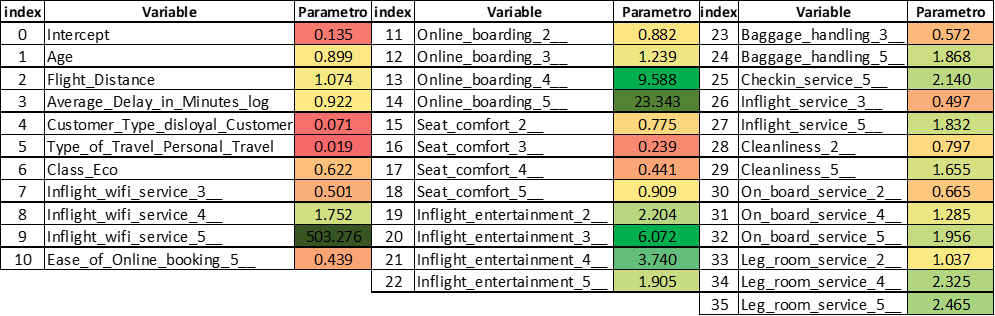

Aunque el hecho de que la selección de variables haya eliminado por completo ciertas variables categóricas, este modelo puede enfatizar en los factores que afectan en mayor grado a la satisfacción de clientes para que la aerolínea pueda focalizar sus esfuerzos en mejorar esos servicios.

Calculamos las inversas para el análisis de los factores

In [118]:
np.mean(df5['Age'])/np.std(df5['Age'])+1

3.607789515673549

In [119]:
np.mean(df5['Flight_Distance'])/np.std(df5['Flight_Distance'])+1

2.1933610888817983

1.	Ante un crecimiento unitario escalado de ‘Age’ (3.6 años) hay un 10% menos de posibilidades que el cliente esté satisfecho.
2.	El crecimiento unitario de ‘Flight_Distance’ (2.2 km) provoca un aumento de probabilidad del 7.4% en la variable respuesta
3.	Un viajero por motivos personales tiene 98% menos posibilidades de estar satisfecho que uno de negocios y un cliente que viaja por primera vez tiene un 93% de estar neutral o satisfecho respecto un cliente leal
4.	Un pasajero Eco tiene 37.8% menos posibilidades de estar satisfecho que siendo EcoPlus o Business
5.	Un servicio de Wifi de puntuación 5 te da una probabilidad mayor a 500 veces de obtener un cliente satisfecho que si tiene una puntuación 1 ó 2.



# 4. Modelos<a id="4"></a>

Una vez seleccionado el set de variables y haber completado el objetivo 1, se van analizar los diferentes algoritmos que puedan mejorar al obtenido por regresión logística. Dado el gran volumen de los datos y el gasto computacional superior, se ha optado por tomar una muestra aleatoria para el análisis de los modelos:

In [121]:
df_model = X_final.join(y.astype('int64'))
df_model.shape

(129880, 36)

In [122]:
df_sample = df_model.sample(frac=0.2)
df_sample.shape

(25976, 36)

In [123]:
df_no_sample = df_model.drop(df_sample.index)
df_no_sample.shape

(103904, 36)

In [124]:
df_sample.duplicated().sum()

0

## 4.1 Redes neuronales<a id="4.1"></a>

El primer modelo que se ha tomado es la construcción de una red neuronal a través de la API de keras de entrenamiento de aprendizaje profundo. Para ello se ha generado una red que emula a la regresión logística (función de activación sigmoide y función de pérdida de entropía cruzada binaria) añadiendo una capa oculta de ocho neuronas. 

In [125]:
X_sample = eliminar_columnas(df_sample, ['satisfaction'])
y_sample = df_sample.satisfaction

In [126]:
model_NN = keras.Sequential()
model_NN.add(keras.layers.Dense(8, input_shape=(X_sample.shape[1],), activation='tanh'))
model_NN.add(keras.layers.Dense(1, activation='sigmoid'))

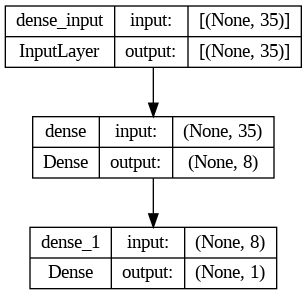

In [127]:
plot_model(model_NN, show_shapes=True)

In [128]:
model_NN.compile( 
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

### 4.1.1 Training - Test

Para conocer la potencia de este modelo, se ha evaluado la red descrita con partición training-test 

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, 
                                                    y_sample, 
                                                    test_size=0.2, 
                                                    random_state=seed)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(20780, 35)
(20780,)
(5196, 35)
(5196,)


In [ ]:
model_NN.fit(X_train, y_train,
         epochs=15, validation_split=0.2,
         batch_size=32)

In [131]:
result = model_NN.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(result[0]))
print('Test AUC: {}'.format(result[1]))

Test Loss: 0.17949342727661133
Test AUC: 0.9284064769744873


### 4.1.2 Validación cruzada repetida

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=3)

accuracy_per_fold = []
loss_per_fold = []
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
# Define the K-fold Cross Validator
kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
for train, test in kfold.split(X, y):
  history = model_NN.fit(X[train], y[train], 
                       epochs=10, 
                       validation_split=0.2, 
                       callbacks=[stop_early])
  scores = model_NN.evaluate(X[test],
                           y[test],
                           verbose=0)
  accuracy_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])

Guardamos los resultado y comparamos con logística

In [133]:
model_df4 = model_acc.copy()

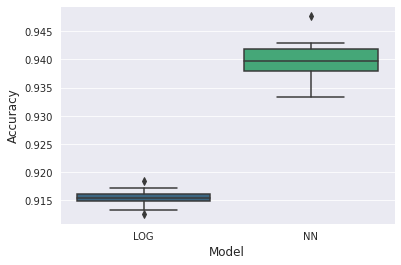

In [134]:
for acc in accuracy_per_fold:
  model_df4.loc[len(model_df4)] = ["NN", acc]
sns.boxplot(
            x=model_df4.columns[0],
            y=model_df4.columns[1],
            data=model_df4, 
            palette='viridis')
plt.show()

## 4.2 Random Forest, Gradient Boosting, Gaussian NB y SVM<a id="4.2"></a>

Una vez completado el análisis de redes, se han tomado una serie de algoritmos que pueden adaptarse a una clasificación binaria:
-	Random Forest: Modelo basado en árboles que tomará diferentes submuestras de entrenamiento y hará predicciones sobre estos tomando un número de variables aleatorio del conjunto de variables.
-	Gradient Boosting: Algoritmo de predicción iterativa en la dirección de decrecimiento del error, también basado en árboles.
-	Gaussian Naive-Bayes: Algoritmo basado en la aplicación del teorema de Bayes con el supuesto "naive" de independencia condicional entre cada par de características dado el valor de la variable de clase, suponiendo la probabilidad de estas variables son gaussianas.
-	Support Vector Machines: Es un algoritmo geométrico que busca el hiperplano que deja máximo margen entre las dos clases aceptando el fallo de observaciones mal separadas. Según el kernel que se utilice habrá tres formas distintas: lineal, polinomial y RBF.


Estos algoritmos están representados de la forma más genérica posible para observar que tipo de modelos se comportan mejor: árboles, geométricos… A partir de estas conclusiones, se indagará en un posible tuneado de alguno de ellos.


In [135]:
RF = ["RF", RandomForestClassifier(random_state=seed)]
GB = ["GB", GradientBoostingClassifier(random_state=seed)]
NB = ["NB", GaussianNB()]
SVL = ["SVL", SVC(random_state=seed, kernel='linear')]
SVP = ["SVP", SVC(random_state=seed, kernel='poly')]
SVR = ["SVR", SVC(random_state=seed, kernel='rbf')]


In [136]:
models42 = [RF, GB, NB, SVL, SVP, SVR]
model_df42 = model_df4.copy()

In [138]:
for name, model in models42:
  cross_val_model(X_sample, y_sample, name, 
                  model_df42, True,  model, False)



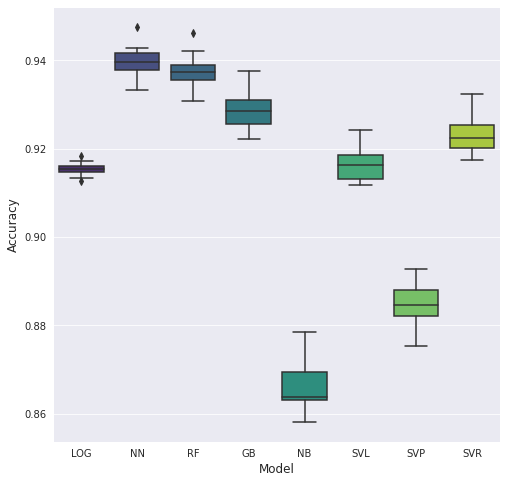

In [139]:
plt.figure(figsize=(8,8))
sns.boxplot(
        x=model_df42.columns[0],
        y=model_df42.columns[1],
        data=model_df42, 
        palette='viridis')
plt.show()

Comparando con los resultados obtenidos en el apartado anterior, el que más se acerca al modelo de redes es el RF seguido de GB. Respecto a los otros, se puede destacar la variante de SVM con kernel RBF. 

In [142]:
"""

path = '/content/drive/My Drive/model_acc2.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  model_df42.to_csv(f)
"""

In [143]:
"""
path = '/content/drive/My Drive/model_acc2.csv'
with open(path, 'r', encoding = 'utf-8-sig') as f:
  model_var = pd.read_csv(f, index_col=0)

model_df42 = model_var
"""

## 4.3 XGBoost<a id="4.3"></a>

El buen comportamiento de los algoritmos con árboles ha inspirado en desarrollar modelos más complejos basados en éstos. En este caso, se ha escogido XGBOOST (Extreme Gradient Boosting). Según su web es una librería optimizada basada en el algoritmo de Gradient Boosting que se adapta a miles de problemas de Machine Learning. 
https://www.datacamp.com/tutorial/xgboost-in-python

Se ha utilizado la función XGBClassifier que es la interfaz de scikit-learn para la clasificación en XGBoost. Se han añadido ciertos parámetros:
-	n_estimators: Número de rondas boosting (1000 en este caso)
-	objective: Clasificación binaria logística
-	tree_method: El algoritmo de construcción de árbol (histograma)
-	eta: También llamado learning_rate se refiere a la frecuencia de reducción de los pesos en cada ronda boosting.


In [141]:
xgb_classifier = xgb.XGBClassifier(n_estimators=1000, 
                                   objective='binary:logistic', 
                                   tree_method='hist', 
                                   eta=0.1, 
                                   max_depth=50)


In [147]:
model_df43 = model_df42.copy()

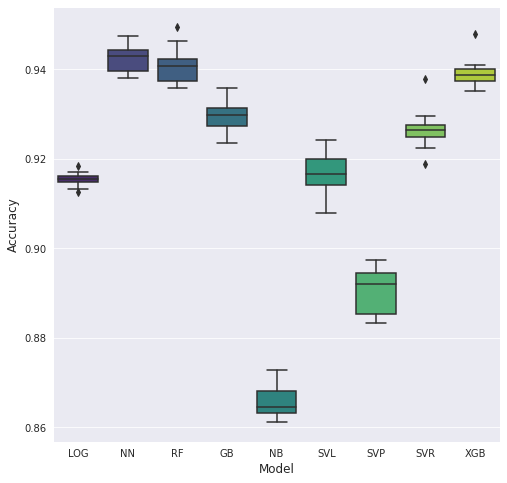

In [148]:
model_df43 = cross_val_model(X_sample, y_sample, "XGB", model_df43,
                True, xgb_classifier)

Se muestran unos resultados muy prometedores, calcando a los obtenidos en las redes neuronales, pero reduciéndose el gasto computacional sobre éste.	

## 4.4 Tree-based Pipeline Optimization Tool (TPOT)<a id="4.4"></a>

Hasta ahora se han abordado diferentes algoritmos que podrían tener un buen comportamiento sobre este tema en específico, pero para descubrir de manera automática modelos que pueden adaptarse al problema existen herramientas de AutoML. 


https://machinelearningmastery.com/automl-libraries-for-python/

Las tres bibliotecas AutoML más populares para scikit-Learn son Hyperopt-Sklearn, Auto-Sklearn y TPOT.
En este caso se ha escogido TPOTClassifier que utiliza una estructura de árboles para representar una cadena de modelos para un problema de modelado predictivo, en el que se incluyen el preprocesamiento de los datos, los algoritmos de modelado, así como los hiperparámetros del modelo. En la búsqueda del mejor algoritmo se han definido los siguientes parámetros:
-	Generation: Número de iteraciones para ejecutar el proceso de optimización del pipeline. (5)
-	Population_size: Número de individuos a retener en la población GP (Genetic Programmation) en cada generación. (50)
-	cv: Validación cruzada repetida.
-	Scoring: Accuracy.


El output de esta función será la evaluación de (5 generación x 50 individuos x 15 validación cruzada) = 3750 modelos diferentes para una muestra de unas treinta mil observaciones


In [ ]:
# define model evaluation
kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
# define search
model_auto = TPOTClassifier(generations=5, population_size=50, 
                       cv=kfold, scoring='accuracy', 
                       verbosity=2, random_state=seed, 
                       n_jobs=-1)
# perform the search
model_auto.fit(X_sample, y_sample)
# export the best model
model_auto.export('tpot_best_model.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9439996290426509

Generation 2 - Current best internal CV score: 0.9444230538878529

Generation 3 - Current best internal CV score: 0.9444230538878529


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=9, min_samples_split=18, n_estimators=100)


Con un accuracy de 0.944 (la máxima obtenido hasta ahora), este es el modelo encontrado por el TPOT.

In [149]:
model_auto = RandomForestClassifier(bootstrap=False, 
                                    criterion='gini', 
                                    max_features=0.65, 
                                    min_samples_leaf=9, 
                                    min_samples_split=18, 
                                    n_estimators=100)

In [150]:
model_df44 = model_df43.copy()

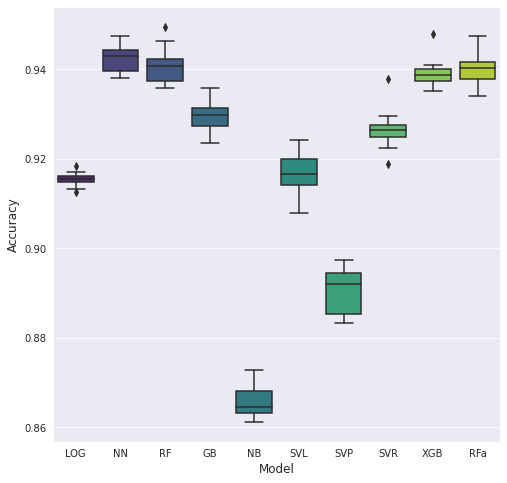

In [151]:
model_df44 = cross_val_model(X_sample, y_sample, "RFa",
                             model_df44, True, model_auto)

Este modelo de Random Forest ha sido evaluado, como los demás, por validación cruzada. Se puede observar que se colocaría como primero en términos de sesgo y varianza según los estudios anteriormente.

# 5. Hiperparametros <a id="5"></a>

En el apartado anterior se ha conseguido un auto modelo que aunaba la optimización del preprocesamiento de datos, la búsqueda de modelos y la hiperparametrización de éstos. Aun así, en la búsqueda de un modelo ad-hoc para este problema se va evaluar el ajuste de unos de los modelos más prometedores, XGBoost. Dado la gran variedad de posibilidades en sus parámetros se ha optado por buscar a través del **Modelo Bayesiano en la optimización de hiperparámetros**.


https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

A diferencia de los otros métodos más utilizados Grid y Random Search, que carecen de información sobre evaluaciones anteriores y pueden dedicar una cantidad significativa de tiempo en la evaluación de hiperparámetros “malos”, el modelo Bayesiano va a centrarse en hiperparámetros que obtengan los mejores resultados. 
En términos generales la optimización bayesiana creará un modelo probabilístico en el que el valor de la función objetivo es la métrica de validación del modelo, en este caso, la exactitud. Por lo tanto, se buscarán los mejores hiperparámetros que rindan mejor en este modelo probabilístico y luego se probará en la verdadera función objetivo de este problema. 

## 5.1 Hyperopt<a id="5.1"></a>

Para la ejecución de este conjunto de hiperparámetros en este caso se ha utilizado mencionado llamado anteriormente, Hyperopt. 

https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9

Para ello se ha definido un espacio que devolverá valores uniformes entre un máximo y mínimo definidos para n_estimators, eta y max_depth, definidos anteriormente en el apartado 4.3 y también para:
-	gamma: Define el mínimo en reducción en la función de pérdida que tiene que haber para que un nodo se pueda dividir
-	colsample_bytree: es la fracción de variables (seleccionadas aleatoriamente) que se utilizarán para entrenar cada árbol.
-	min_child_weight: Define la suma mínima de los pesos de los hijos que deben tener todas las observaciones.


In [152]:
space={
    'n_estimators': hp.quniform('reg_alpha', 500, 2500, 1),
    'eta': hp.uniform('eta', 0, 1),
    'gamma': hp.uniform ('gamma', 1, 9), 
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
    }

In [ ]:
# Classifier:
def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(n_estimators = int(space['n_estimators']),
                              eta  = space['eta'],
                              max_depth = int(space['max_depth']), 
                              gamma = space['gamma'], 
                              min_child_weight=space['min_child_weight'],
                              colsample_bytree=space['colsample_bytree'],
                              seed=seed
    )
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, 
            early_stopping_rounds=10, 
            verbose=False)

    pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}


Se van a evaluar 100 modelos y buscaremos el que minimice la función de pérdida utilizando el algoritmo Tree-structured Parzen Estimator (TPE)

In [ ]:

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

Los siguientes parámetros son los escogidos como los óptimos para el problema:

In [153]:
best = {'colsample_bytree': 0.9803443692967216,
 'eta': 0.1191112399535662,
 'gamma': 3.8567843554108734,
 'max_depth': 14.0,
 'min_child_weight': 4.0,
 'reg_alpha': 564.0}

In [154]:
xgboost_bo = xgb.XGBClassifier(
    seed=seed, 
    colsample_bytree=space_eval(space, best)['colsample_bytree'], 
    gamma=space_eval(space, best)['gamma'], 
    eta=space_eval(space, best)['eta'], 
    max_depth=int(space_eval(space, best)['max_depth']), 
    min_child_weight=int(space_eval(space, best)['min_child_weight']),
    n_estimators=int(space_eval(space, best)['n_estimators'])
                           )

In [155]:
model_df51 = model_df44.copy()

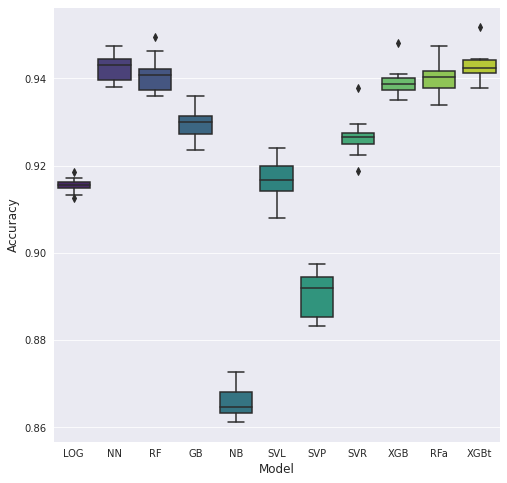

In [156]:
model_df51 = cross_val_model(X_sample, y_sample, "XGBt",
                             model_df51, True, xgboost_bo)

El último modelo mejora 0,1 puntos porcentuales el encontrado por AutoML teniendo una variabilidad menor.

## 5.2 Elección del modelo ganador<a id="5.2"></a>

El segundo objetivo de este proyecto es la obtención de un modelo que nos permita predecir el resto del dataset (para la mayoría de ellos se ha utilizado una muestra) y también para poder predecir la satisfacción de clientes en un informe mensual donde una vez obtenido las variables input. Como introducción se muestra una tabla con los resultados de la media de la exactitud obtenida por validación cruzada repetida y la desviación típica obtenida.

In [157]:
tabla_modelos = model_df51.groupby('Model')['Accuracy'] \
    .agg(mean='mean', std='std')

In [158]:
tabla_modelos

,mean,std
Model,,
GB,0.929409,0.003459
LOG,0.915432,0.001493
NB,0.865825,0.003352
NN,0.942704,0.003026
RF,0.940637,0.003854
RFa,0.939880,0.003347
SVL,0.917000,0.004290
SVP,0.890784,0.004878
SVR,0.926535,0.004123


A través del tuneado de XGBoost se ha conseguido una mejora de los resultados reduciendo la variabilidad hasta casi alcanzar la que se mostró inicialmente en la logística. Ahora para probar el modelo se ha tomado el 80% de los datos que no se utilizaron para el entrenamiento de los modelos no logísticos. Estos datos se han divido en Training-Test (80-20).

In [ ]:
X_no_sample = eliminar_columnas(df_no_sample, ['satisfaction'])
y_no_sample = df_no_sample.satisfaction

In [ ]:
modelF = xgboost_bo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_no_sample, 
                                                    y_no_sample, 
                                                    test_size=0.2, 
                                                    random_state=seed)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(83123, 35)
(83123,)
(20781, 35)
(20781,)


In [ ]:
modelF.fit(X_train, y_train, verbose = False, eval_set=[(X_test, y_test)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9803443692967216, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1191112399535662,
              eval_metric=None, feature_types=None, gamma=3.8567843554108734,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=564, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

 A continuación se representa la función de densidad de las predicciones del modelo distinguidas por y_test real

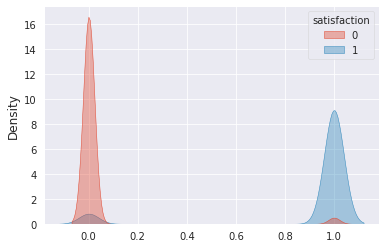

In [ ]:
## BUscamos el mejor punto de corte
y_pred = modelF.predict(X_test)

plt.clf()
sns.kdeplot(x=y_pred, hue=y_test, 
            fill=True, common_norm=False, 
            alpha=0.4)
plt.show()

Se puede observar que el modelo aproxima a valores muy cercanos a 0 ó a 1, siendo el error menor para el evento, es decir cliente satisfecho. Pero se puede ver mejor en la matriz de confusión.

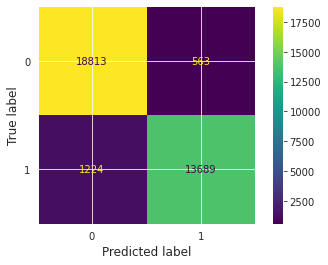

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
plt.show()

Aquí se puede ver que el modelo clasifica con gran exactitud y que prevalece el error tipo II sobre el tipo I. Para definir la sensibilidad y especificidad se ha incluido además un informe de clasificación.

In [ ]:
# Reporte de clasificación 
print(metrics.classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     19376
           1       0.96      0.92      0.94     14913

    accuracy                           0.95     34289
   macro avg       0.95      0.94      0.95     34289
weighted avg       0.95      0.95      0.95     34289



## 5.3 Discusión de los resultados del modelo<a id="5.3"></a>

Al utilizar un método más complejo que el logístico surgen dificultades a la hora de explicar los resultados. Incluso hay ocasiones que por transparencia en necesaria una interpretación del modelo propuesto. En este caso se ha utilizado la librería SHAP en su variante TreeExplainer para el modelo XGBoost

In [ ]:
explainer = shap.TreeExplainer(modelF) 
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.initjs()

### 5.3.1 Summary plots

De esta librería se han representado dos gráficos:

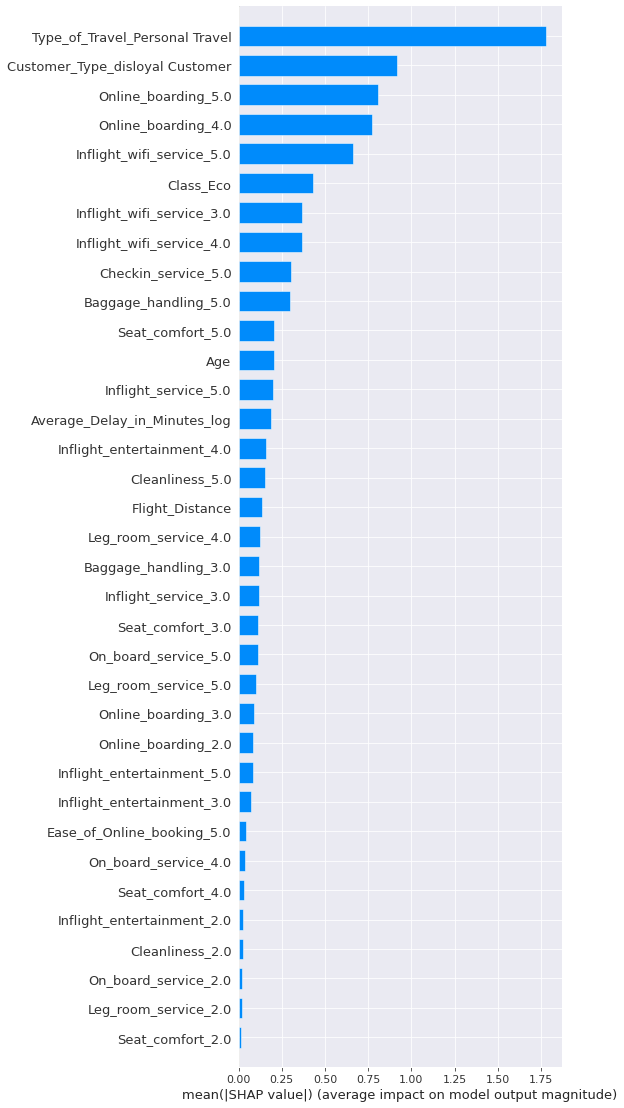

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=35)

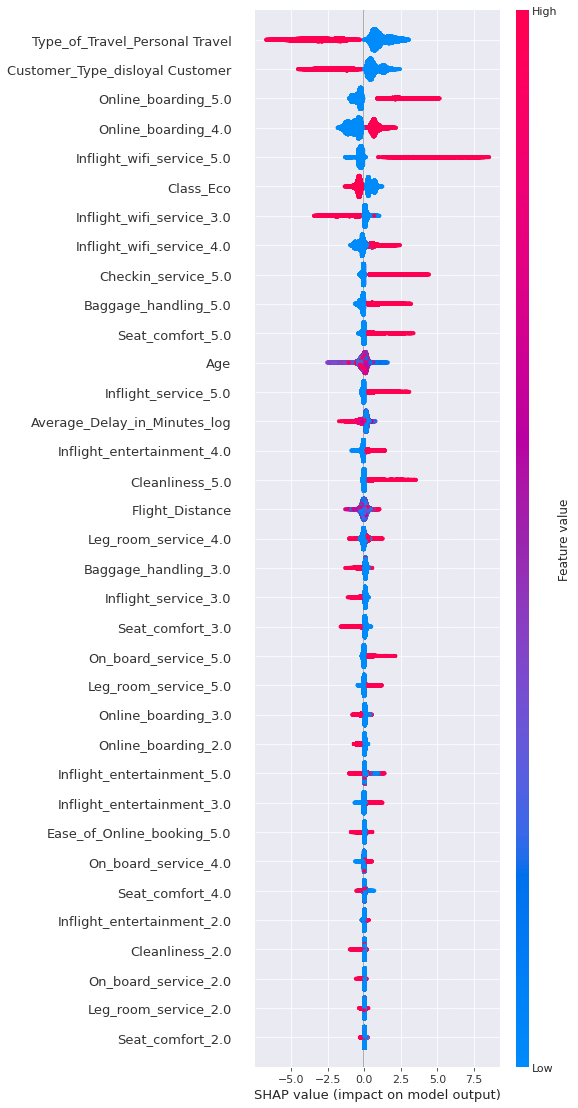

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_train, max_display=35)

El primero representa la media del valor SHAP de todas las observaciones, es decir, el impacto medio que tiene en la variable respuesta si esta es escondida. El segundo apila todas las observaciones en cada variable y a través del color y la posición de este punto) nos dará la importancia que tiene esa variable para esa observación a través de su distancia al eje. (Puntos alejados del eje nos hablará que ese grupo está afectado positivamente, si está a la derecha, o negativamente, si está a la izquierda, en la satisfacción del cliente). A partir de estos gráficos se pueden interpretar los siguientes resultados:
-	Las variables binarias de tipo de viaje y tipo de cliente se muestran como las más influyentes en el modelo. Además, en el caso que sea el motivo de viaje personal y el cliente nuevo esta influencia será negativa respecto a la satisfacción.
-	La puntuación máxima en el embarque online y el servicio Wi-Fi corresponden a la tercera y quinta posición por importancia. Es de destacar que en el caso de Wi-Fi la importancia que tiene para un grupo de los estudiados es muy grande.
-	En general, para las siguientes variables que indican satisfacción de 5 puntos, el SHAP value para las observaciones que lo poseen es alto y positivo, mientras si no lo poseen no es muy significativo. Por el contrario, para las variables que no poseen 3 puntos o 2 puntos (indicando que el valor es menor a éste), el SHAP value será alto y negativo cuando no aparece, y no significativo para cuando si aparece.
-	En cuanto a edad, solo se ven ciertas observaciones una contribución alta y negativa para edades alejadas. Lo mismo ocurre con la media de los retrasos.



# 6. Informe final de conclusiones<a id="6"></a>

Este trabajo hay tenido unas fases muy estándar a cualquier trabajo de Machine Learning de clasificación. El objetivo de esta clasificación era determinar los factores que influyen en un pasajero a la hora de estar satisfecho o no con el servicio recibido por la aerolínea y poder predecir su satisfacción o no con los datos que toma la aerolínea a través de sus encuestas y datos generales del cliente. 
Dado el gran número variables y de observaciones ha sido crucial un análisis descriptivo para conocer la distribución de las variables y el tipo y rol que estas tomaban en el problema. También se ha realizado un análisis de importancia de estas variables de las que podemos destacar:
-	Respecto a los datos del cliente, pasajeros que viajan por motivos personales y que no están fidelizados tienen una probabilidad alta de ser neutrales o estar insatisfechos con la aerolínea y estas dos variables tienen un peso muy alto.
-	Categorías como servicio a Wi-Fi o embarque online tienen un gran valor positivo en la satisfacción del cliente.
-	En general, la satisfacción no se ve afectada por los retrasos de la aerolínea.

Estas conclusiones se han sacado de un modelo sencillo de poco gasto computacional y muy explicable, pero la exactitud solo alcanza el 91%. Para aumentar la capacidad predictiva, se han explorado modelos más complejos que ofrezcan mejores prestaciones. En este caso se ha alcanzado con un modelo llamado XGBoost una potencia predictiva del 95%, cumpliendo con unos estándares altos.

También, en el apartado 5.3, aparece un gráfico que indica la importancia que tienen las variables escogidas en las distintas observaciones y sobre el modelo. Por ejemplo, la aerolínea podría anotar que una mejora en el servicio Wi-Fi o paliar la insatisfacción o neutralidad en pasajeros que viajan por motivos personales tendrían un impacto muy grande y podrían revertir los resultados de 43-57% satisfechos-neutrales o insatisfechos.  

Como mejora futura, una vez realizada las predicciones sobre un nuevo conjunto de datos, se propone una revisión continua de la selección de variables según la importancia de éstas siguiendo los pasos del apartado 3.3. A partir de estas nuevas variables se podrían identificar nuevos patrones en el consumo y satisfacción de los clientes. Este nuevo set de variables debería seguir los pasos del apartado 5.2 para conocer la exactitud, especificidad y sensibilidad. Si, por un casual, estos valores no alcanzasen los estándares de la aerolínea, se podría introducir esta nueva selección de variables en los modelos definidos desde el apartado 4.
